In [276]:
import os
import re
import random
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.preprocessing import StandardScaler
from scripts.data_cleaning import clean_data
import itertools

In [277]:
import warnings
warnings.filterwarnings('ignore')

In [278]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [279]:
SEED = 1971

In [280]:
# clean data 
train.set_index("id", inplace=True)
test.set_index("id", inplace=True)
cleaned_train_orig = clean_data(train)
cleaned_test_orig = clean_data(test)

In [281]:
# # # chnage pass to cat col
# cleaned_test_orig["passport"] = cleaned_test_orig["passport"].astype('object')
# cleaned_train_orig["passport"] = cleaned_train_orig["passport"].astype('object')

In [282]:
CAT_COL  = cleaned_test_orig.select_dtypes(include=['object', 'category']).columns
NUM_COL = [col for col in cleaned_test_orig.columns if col not in CAT_COL]
CONT_COl = ["age", "duration_of_pitch", "monthly_income"]

In [8]:
# plt.figure(figsize=(8, 15)) 

# for i, column in enumerate(NUM_COL):
#     plt.subplots()
#     sns.histplot(data=cleaned_train_orig, x=column, kde=True, bins=20, color="red", alpha=0.5)
#     sns.histplot(data=cleaned_test_orig, x=column, kde=True, bins=20)
    
#     plt.title(f'Distribution of {column}')
#     sns.despine()

# plt.tight_layout()  # Adjust subplots to fit into figure area.
# plt.show()

In [9]:
# for column in NUM_COL:
#     plt.figure(figsize=(8, 6))
#     sns.violinplot(data=cleaned_train_orig, x='prod_taken', y=column) 
#     plt.title(f'Distribution of {column} by class')

#     plt.tight_layout()
#     plt.show()

In [10]:
# # Plot mosaic plots for each categorical column, excluding "Unknown" values
# from statsmodels.graphics.mosaicplot import mosaic
# for column in CAT_COL:
#     # Exclude "Unknown" values from the DataFrame
#     filtered_data = cleaned_train_orig.loc[cleaned_train_orig[column] != 'Unknown']
    
#     plt.figure(figsize=(8, 6))
#     mosaic(filtered_data, [column, 'prod_taken'])
#     plt.title(f'Mosaic Plot of {column} and class')

#     plt.tight_layout()
#     plt.show()

In [11]:
# # Calculate the Z-scores for the numerical columns in the DataFrame
# from scipy import stats
# z_scores = stats.zscore(cleaned_train_orig[NUM_COL].fillna(cleaned_train_orig[NUM_COL].mean()))

# # Generate descriptive statistics for the Z-scores and round the results to 3 decimal places
# pd.DataFrame(z_scores, columns=NUM_COL).describe().round(3)

In [12]:
# cleaned_train_orig

In [283]:
# data preparation 
train = cleaned_train_orig.drop("prod_taken", axis=1)
y = cleaned_train_orig["prod_taken"]
test = cleaned_test_orig.copy()

In [14]:
# train

In [15]:

# k = 3
# f=1.5


# scores = []
# tr_scores = []

# skf = StratifiedKFold(n_splits=5, random_state = SEED, shuffle = True)

# for train_index, valid_index in skf.split(train, y):
#     train_df, valid_df, train_y, valid_y = train.loc[train_index], train.loc[valid_index], y.loc[train_index], y.loc[valid_index]

#     te = TargetEncoder(
#         categories= CAT_COL,
#         k = 1 , f = 1
#     )

#     X_tr = te.fit_transform(train_df, train_y)
#     X_val = te.transform(valid_df).values

#     model = get_model("linear")
# #                 model = xgb.XGBClassifier(**params)
#     model.fit(X_tr, train_y)

#     predictions = model.predict_proba(X_val)[:,1]
#     scores.append(roc_auc_score(valid_y, predictions))

#     train_preds = model.predict_proba(X_tr)[:,1]
#     tr_scores.append(roc_auc_score(train_y, train_preds))

# print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
#     np.mean(tr_scores), np.mean(scores), np.std(scores)
# ))




In [137]:
import optuna
from sklearn.svm import SVC
def objective(trial):
    
    params = {
            "objective": "binary:logistic",
            "n_estimators": trial.suggest_int("n_estimators", 200, 3000),
            "verbosity": 0,
            "booster" : "gbtree",
            "eval_metric": "auc",
            "tree_method": 'exact',
            'random_state': 1971,
        
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
            "max_depth": trial.suggest_int("max_depth", 1, 10),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
            'gamma': trial.suggest_uniform('gamma', 1, 9)

        }
    
#     svc_params = {
     # Hyperparameters to be tuned
#      "C" : trial.suggest_loguniform('C', 1e-5, 1e2),
#      "kernel" : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    #      "degree" = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
#      "degree": 3,
#      "gamma" : trial.suggest_categorical('gamma', ['scale', 'auto'])}
#     log_params  = {
#         'tol' : trial.suggest_uniform('tol' , 1e-6 , 1e-3),
#         'C' : trial.suggest_loguniform("C", 1e-2, 1),
#        # 'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
#        #  'random_state' : trial.suggest_categorical('random_state' , [0, 42, 2021, 555]),
#        # 'solver' : trial.suggest_categorical('solver' , ['lbfgs','liblinear']),
#         "n_jobs" : -1
#     }

    
    k = trial.suggest_float("k", 1, 5)
    f = trial.suggest_float("f", 1.5, 40)
    w = trial.suggest_int("smoothing", 10, 30)
    missing_col = trial.suggest_int("missing", 5, 50)
#     k = 1
#     f = 25
    
    scores = []
    tr_scores = []

    skf = StratifiedKFold(n_splits=5, random_state = SEED, shuffle = True)

    for train_index, valid_index in skf.split(train, y):
        train_df, valid_df, train_y, valid_y = train.loc[train_index], train.loc[valid_index], y.loc[train_index], y.loc[valid_index]

        train_df = create_random_nan(train_df, 40)
        X_tr, X_val = create_feature(train_df, valid_df, train_y, CAT_COL, NUM_COL, CONT_COl, cv =skf, w=w, k=k,f=f)

        

#         model = get_model("xgb")
#         model = LogisticRegression(**log_params)
        model = xgb.XGBClassifier(**params)
        evaluation = [( X_tr, train_y), ( X_val, valid_y)]

        model.fit(X_tr, train_y, eval_set=evaluation, early_stopping_rounds=20, verbose=False)

        predictions = model.predict_proba(X_val)[:,1]
        scores.append(roc_auc_score(valid_y, predictions))

        train_preds = model.predict_proba(X_tr)[:,1]
        tr_scores.append(roc_auc_score(train_y, train_preds))

#     print(scores)
    print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
        np.mean(tr_scores), np.mean(scores), np.std(scores)))


    return np.mean(scores)


In [138]:
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(study_name="target_enc", direction='maximize', sampler=sampler)

study.optimize(objective,  n_trials=100)


# log best hyperparameters

print('Best hyperparameters:', study.best_params)
print('Best auc:', study.best_value)

[I 2024-08-18 19:08:21,137] A new study created in memory with name: target_enc
[I 2024-08-18 19:08:29,246] Trial 0 finished with value: 0.8379820910260047 and parameters: {'n_estimators': 799, 'learning_rate': 0.12071509934476166, 'max_depth': 1, 'subsample': 0.6381338566608813, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3, 'gamma': 1.0132881972643952, 'k': 4.272028979734923, 'f': 14.631645378533952, 'smoothing': 23, 'missing': 27}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8490 Valid AUC score: 0.8380, STD: 0.0173


[I 2024-08-18 19:08:35,909] Trial 1 finished with value: 0.8311996622412533 and parameters: {'n_estimators': 370, 'learning_rate': 0.1591168509416555, 'max_depth': 7, 'subsample': 0.35099248825336493, 'colsample_bytree': 0.24133046673504516, 'min_child_weight': 8, 'gamma': 3.5923452785268584, 'k': 3.598531265617436, 'f': 33.14866499525509, 'smoothing': 13, 'missing': 14}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8703 Valid AUC score: 0.8312, STD: 0.0192


[I 2024-08-18 19:08:43,994] Trial 2 finished with value: 0.8251413363680186 and parameters: {'n_estimators': 1051, 'learning_rate': 0.34753426470361587, 'max_depth': 8, 'subsample': 0.3163048793925822, 'colsample_bytree': 0.8947396976060866, 'min_child_weight': 13, 'gamma': 7.694109720804697, 'k': 4.0453083593782555, 'f': 17.22567005825312, 'smoothing': 19, 'missing': 18}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8451 Valid AUC score: 0.8251, STD: 0.0235


[I 2024-08-18 19:08:54,088] Trial 3 finished with value: 0.8218748302337616 and parameters: {'n_estimators': 2051, 'learning_rate': 0.017965630391859264, 'max_depth': 10, 'subsample': 0.5924709329864083, 'colsample_bytree': 0.7343693140063804, 'min_child_weight': 14, 'gamma': 6.485327570924542, 'k': 2.426141674451309, 'f': 6.823575954071607, 'smoothing': 20, 'missing': 45}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8319 Valid AUC score: 0.8219, STD: 0.0157


[I 2024-08-18 19:09:03,834] Trial 4 finished with value: 0.8205281911075625 and parameters: {'n_estimators': 1707, 'learning_rate': 0.012211290992287282, 'max_depth': 8, 'subsample': 0.4720598603683397, 'colsample_bytree': 0.19894465698017433, 'min_child_weight': 3, 'gamma': 3.573469779792495, 'k': 2.803027984146616, 'f': 38.16341794915995, 'smoothing': 24, 'missing': 7}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8449 Valid AUC score: 0.8205, STD: 0.0247


[I 2024-08-18 19:09:20,190] Trial 5 finished with value: 0.8313097979984094 and parameters: {'n_estimators': 2837, 'learning_rate': 0.02233673071988183, 'max_depth': 2, 'subsample': 0.9746882335047107, 'colsample_bytree': 0.6975099530700135, 'min_child_weight': 3, 'gamma': 2.166287191152761, 'k': 2.6843783800754584, 'f': 8.74237886104141, 'smoothing': 23, 'missing': 23}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8577 Valid AUC score: 0.8313, STD: 0.0208


[I 2024-08-18 19:09:28,240] Trial 6 finished with value: 0.8294203483402148 and parameters: {'n_estimators': 2422, 'learning_rate': 0.36218975292714783, 'max_depth': 3, 'subsample': 0.8450555914478488, 'colsample_bytree': 0.7905244987889579, 'min_child_weight': 19, 'gamma': 6.844208536066087, 'k': 2.413566701273322, 'f': 19.150664274902752, 'smoothing': 28, 'missing': 35}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8579 Valid AUC score: 0.8294, STD: 0.0145


[I 2024-08-18 19:09:36,110] Trial 7 finished with value: 0.8322806235847174 and parameters: {'n_estimators': 1045, 'learning_rate': 0.3135101068815588, 'max_depth': 10, 'subsample': 0.4722482011524167, 'colsample_bytree': 0.3474855570622388, 'min_child_weight': 6, 'gamma': 3.3298122143196345, 'k': 4.404356138534416, 'f': 25.04299753283757, 'smoothing': 14, 'missing': 6}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8814 Valid AUC score: 0.8323, STD: 0.0184


[I 2024-08-18 19:09:45,288] Trial 8 finished with value: 0.8332178171968764 and parameters: {'n_estimators': 273, 'learning_rate': 0.19307560283920278, 'max_depth': 10, 'subsample': 0.7297220454372869, 'colsample_bytree': 0.0841097914914904, 'min_child_weight': 14, 'gamma': 4.342183957525648, 'k': 2.6001627107803276, 'f': 22.61592268313252, 'smoothing': 18, 'missing': 10}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8561 Valid AUC score: 0.8332, STD: 0.0181


[I 2024-08-18 19:09:53,170] Trial 9 finished with value: 0.8281583963486774 and parameters: {'n_estimators': 2622, 'learning_rate': 0.4259080134567616, 'max_depth': 4, 'subsample': 0.9682434115890504, 'colsample_bytree': 0.9450636769231806, 'min_child_weight': 8, 'gamma': 1.7877637296175521, 'k': 1.3679504979870725, 'f': 21.77317211118162, 'smoothing': 12, 'missing': 39}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.9182 Valid AUC score: 0.8282, STD: 0.0192


[I 2024-08-18 19:10:02,805] Trial 10 finished with value: 0.8240187260458365 and parameters: {'n_estimators': 937, 'learning_rate': 0.05849251189498842, 'max_depth': 1, 'subsample': 0.1053812145529317, 'colsample_bytree': 0.5233871754946897, 'min_child_weight': 2, 'gamma': 1.244735978871753, 'k': 4.8121340125495555, 'f': 12.705523771015724, 'smoothing': 29, 'missing': 29}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8265 Valid AUC score: 0.8240, STD: 0.0243


[I 2024-08-18 19:10:13,748] Trial 11 finished with value: 0.8269134731212834 and parameters: {'n_estimators': 301, 'learning_rate': 0.10649470035523248, 'max_depth': 5, 'subsample': 0.7267148162717806, 'colsample_bytree': 0.05799230949571389, 'min_child_weight': 17, 'gamma': 5.625839552056291, 'k': 1.5431642087878243, 'f': 27.67391645567224, 'smoothing': 16, 'missing': 27}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8377 Valid AUC score: 0.8269, STD: 0.0238


[I 2024-08-18 19:10:26,959] Trial 12 finished with value: 0.8274681275713794 and parameters: {'n_estimators': 653, 'learning_rate': 0.05174475663950424, 'max_depth': 6, 'subsample': 0.6450226488003313, 'colsample_bytree': 0.4867209484831351, 'min_child_weight': 12, 'gamma': 8.691366767434523, 'k': 3.5361670679398576, 'f': 13.881689092555458, 'smoothing': 24, 'missing': 50}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8419 Valid AUC score: 0.8275, STD: 0.0216


[I 2024-08-18 19:10:45,593] Trial 13 finished with value: 0.837898375607601 and parameters: {'n_estimators': 1422, 'learning_rate': 0.14470877222955517, 'max_depth': 1, 'subsample': 0.7344181402028118, 'colsample_bytree': 0.61977365120927, 'min_child_weight': 15, 'gamma': 4.463763345564596, 'k': 3.3932247209024227, 'f': 2.640310829381379, 'smoothing': 18, 'missing': 14}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8459 Valid AUC score: 0.8379, STD: 0.0186


[I 2024-08-18 19:11:00,969] Trial 14 finished with value: 0.8368891348141185 and parameters: {'n_estimators': 1429, 'learning_rate': 0.09766189634615398, 'max_depth': 1, 'subsample': 0.7778147829936404, 'colsample_bytree': 0.6332605544192279, 'min_child_weight': 17, 'gamma': 5.194355102680207, 'k': 3.7264749056824615, 'f': 1.6591061658486854, 'smoothing': 10, 'missing': 19}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8484 Valid AUC score: 0.8369, STD: 0.0182


[I 2024-08-18 19:11:13,906] Trial 15 finished with value: 0.8312898357278122 and parameters: {'n_estimators': 1500, 'learning_rate': 0.038220956750406265, 'max_depth': 3, 'subsample': 0.8433077222902552, 'colsample_bytree': 0.9889172098402343, 'min_child_weight': 10, 'gamma': 2.5256914691489767, 'k': 4.9568875080148445, 'f': 1.6292505823214078, 'smoothing': 22, 'missing': 31}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8592 Valid AUC score: 0.8313, STD: 0.0196


[I 2024-08-18 19:11:24,570] Trial 16 finished with value: 0.834256086275793 and parameters: {'n_estimators': 1927, 'learning_rate': 0.18164560835696003, 'max_depth': 2, 'subsample': 0.5201767819109737, 'colsample_bytree': 0.854157205684158, 'min_child_weight': 5, 'gamma': 1.1085241667654173, 'k': 3.3072836191401196, 'f': 9.272151003863979, 'smoothing': 26, 'missing': 22}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8709 Valid AUC score: 0.8343, STD: 0.0174


[I 2024-08-18 19:11:36,161] Trial 17 finished with value: 0.8368663753520034 and parameters: {'n_estimators': 1332, 'learning_rate': 0.10163205008221969, 'max_depth': 1, 'subsample': 0.6731908998311108, 'colsample_bytree': 0.5991282325290336, 'min_child_weight': 20, 'gamma': 4.544189141266158, 'k': 4.24503971532906, 'f': 6.462881735841398, 'smoothing': 17, 'missing': 14}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8494 Valid AUC score: 0.8369, STD: 0.0183


[I 2024-08-18 19:11:46,561] Trial 18 finished with value: 0.8203378485329562 and parameters: {'n_estimators': 831, 'learning_rate': 0.031457659643281746, 'max_depth': 4, 'subsample': 0.3647845751753662, 'colsample_bytree': 0.3980999717060614, 'min_child_weight': 16, 'gamma': 2.7752918412941163, 'k': 1.8498294222482452, 'f': 15.012655523933748, 'smoothing': 21, 'missing': 38}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8330 Valid AUC score: 0.8203, STD: 0.0240


[I 2024-08-18 19:11:55,727] Trial 19 finished with value: 0.834615304191264 and parameters: {'n_estimators': 576, 'learning_rate': 0.2294681104496143, 'max_depth': 2, 'subsample': 0.8706170139705511, 'colsample_bytree': 0.8204648443133564, 'min_child_weight': 11, 'gamma': 6.336692372453561, 'k': 3.2656957542744927, 'f': 28.359517271348942, 'smoothing': 16, 'missing': 26}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8581 Valid AUC score: 0.8346, STD: 0.0180


[I 2024-08-18 19:12:05,373] Trial 20 finished with value: 0.8347999381760722 and parameters: {'n_estimators': 1216, 'learning_rate': 0.12793630324695202, 'max_depth': 3, 'subsample': 0.6155506405331245, 'colsample_bytree': 0.6243535407428831, 'min_child_weight': 1, 'gamma': 8.93455347275599, 'k': 4.621649448586342, 'f': 4.6922976838554575, 'smoothing': 26, 'missing': 14}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8584 Valid AUC score: 0.8348, STD: 0.0171


[I 2024-08-18 19:12:17,440] Trial 21 finished with value: 0.8352907081828835 and parameters: {'n_estimators': 1723, 'learning_rate': 0.07469696848127783, 'max_depth': 1, 'subsample': 0.7617398079184804, 'colsample_bytree': 0.6450693710042213, 'min_child_weight': 17, 'gamma': 5.509627087890714, 'k': 3.930256696339333, 'f': 2.3337546408443934, 'smoothing': 10, 'missing': 20}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8446 Valid AUC score: 0.8353, STD: 0.0204


[I 2024-08-18 19:12:30,375] Trial 22 finished with value: 0.8369850064003727 and parameters: {'n_estimators': 1357, 'learning_rate': 0.07729190222827435, 'max_depth': 1, 'subsample': 0.7722429814422044, 'colsample_bytree': 0.44530182289468495, 'min_child_weight': 16, 'gamma': 4.9894330681934065, 'k': 3.768972556433335, 'f': 10.406459981803517, 'smoothing': 11, 'missing': 19}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8479 Valid AUC score: 0.8370, STD: 0.0182


[I 2024-08-18 19:12:41,675] Trial 23 finished with value: 0.8370637557421329 and parameters: {'n_estimators': 1232, 'learning_rate': 0.06921005020680362, 'max_depth': 2, 'subsample': 0.890686803568629, 'colsample_bytree': 0.4275307742930964, 'min_child_weight': 15, 'gamma': 4.453783244425863, 'k': 3.1174521143654523, 'f': 10.435765233576525, 'smoothing': 15, 'missing': 16}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8553 Valid AUC score: 0.8371, STD: 0.0179


[I 2024-08-18 19:12:49,889] Trial 24 finished with value: 0.8366996389487135 and parameters: {'n_estimators': 625, 'learning_rate': 0.24411356724116215, 'max_depth': 2, 'subsample': 0.9078425961629679, 'colsample_bytree': 0.31164181947790387, 'min_child_weight': 9, 'gamma': 4.151907426579704, 'k': 3.0251528868837463, 'f': 10.6152454484668, 'smoothing': 15, 'missing': 10}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8614 Valid AUC score: 0.8367, STD: 0.0180


[I 2024-08-18 19:12:59,065] Trial 25 finished with value: 0.8317711023501835 and parameters: {'n_estimators': 2033, 'learning_rate': 0.13359383481078993, 'max_depth': 3, 'subsample': 0.6769543358735073, 'colsample_bytree': 0.5732695692463484, 'min_child_weight': 15, 'gamma': 3.1177444243723422, 'k': 2.0611293751944384, 'f': 5.88614973807621, 'smoothing': 19, 'missing': 16}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8670 Valid AUC score: 0.8318, STD: 0.0139


[I 2024-08-18 19:13:09,902] Trial 26 finished with value: 0.825406056534096 and parameters: {'n_estimators': 1178, 'learning_rate': 0.04780042653476428, 'max_depth': 4, 'subsample': 0.9182638215048632, 'colsample_bytree': 0.7431713992566182, 'min_child_weight': 12, 'gamma': 7.662267910007777, 'k': 3.3477969536805463, 'f': 14.93476108083184, 'smoothing': 21, 'missing': 33}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8463 Valid AUC score: 0.8254, STD: 0.0183


[I 2024-08-18 19:13:20,391] Trial 27 finished with value: 0.8354377654919499 and parameters: {'n_estimators': 801, 'learning_rate': 0.07352532494544856, 'max_depth': 2, 'subsample': 0.5796856561376135, 'colsample_bytree': 0.4347173022641335, 'min_child_weight': 6, 'gamma': 1.94866715400634, 'k': 4.307055627421486, 'f': 17.44053131396211, 'smoothing': 18, 'missing': 10}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8529 Valid AUC score: 0.8354, STD: 0.0144


[I 2024-08-18 19:13:31,176] Trial 28 finished with value: 0.833833048944394 and parameters: {'n_estimators': 1668, 'learning_rate': 0.13664813557678712, 'max_depth': 5, 'subsample': 0.8283040331352974, 'colsample_bytree': 0.24750064414345235, 'min_child_weight': 19, 'gamma': 4.02917847550406, 'k': 3.040742062970456, 'f': 12.232189731207386, 'smoothing': 14, 'missing': 23}. Best is trial 0 with value: 0.8379820910260047.


Train AUC score: 0.8666 Valid AUC score: 0.8338, STD: 0.0185


[I 2024-08-18 19:13:43,674] Trial 29 finished with value: 0.8379914960234333 and parameters: {'n_estimators': 2277, 'learning_rate': 0.16930932320144249, 'max_depth': 1, 'subsample': 0.3966771258760083, 'colsample_bytree': 0.1640640265834592, 'min_child_weight': 11, 'gamma': 5.928781158535099, 'k': 1.0640100808335542, 'f': 4.003780047904594, 'smoothing': 14, 'missing': 13}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8393 Valid AUC score: 0.8380, STD: 0.0156


[I 2024-08-18 19:13:52,606] Trial 30 finished with value: 0.831774448833932 and parameters: {'n_estimators': 2362, 'learning_rate': 0.26078499209384765, 'max_depth': 6, 'subsample': 0.35572784816888725, 'colsample_bytree': 0.30515241640721763, 'min_child_weight': 10, 'gamma': 7.128544124446455, 'k': 2.1030242279961917, 'f': 33.426766455125936, 'smoothing': 13, 'missing': 11}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8424 Valid AUC score: 0.8318, STD: 0.0179


[I 2024-08-18 19:14:01,152] Trial 31 finished with value: 0.8146610743421734 and parameters: {'n_estimators': 2172, 'learning_rate': 0.1397658559387046, 'max_depth': 1, 'subsample': 0.26139409967360155, 'colsample_bytree': 0.15759064079461543, 'min_child_weight': 13, 'gamma': 6.073248793835903, 'k': 3.480250739816877, 'f': 5.023537284786839, 'smoothing': 16, 'missing': 14}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8149 Valid AUC score: 0.8147, STD: 0.0180


[I 2024-08-18 19:14:09,730] Trial 32 finished with value: 0.8324692011995489 and parameters: {'n_estimators': 1846, 'learning_rate': 0.18435797468432236, 'max_depth': 2, 'subsample': 0.4426237346753615, 'colsample_bytree': 0.16466628664703825, 'min_child_weight': 8, 'gamma': 4.882243996408427, 'k': 4.014098456325224, 'f': 7.825222124267972, 'smoothing': 13, 'missing': 17}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8478 Valid AUC score: 0.8325, STD: 0.0135


[I 2024-08-18 19:14:20,957] Trial 33 finished with value: 0.8341995959167333 and parameters: {'n_estimators': 1558, 'learning_rate': 0.09316787751365789, 'max_depth': 1, 'subsample': 0.4235583775413687, 'colsample_bytree': 0.8967674076427878, 'min_child_weight': 13, 'gamma': 5.897321811289363, 'k': 2.9653264953700273, 'f': 3.819709913308936, 'smoothing': 19, 'missing': 5}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8423 Valid AUC score: 0.8342, STD: 0.0172


[I 2024-08-18 19:14:30,685] Trial 34 finished with value: 0.8157030640800329 and parameters: {'n_estimators': 1140, 'learning_rate': 0.1490388755115693, 'max_depth': 2, 'subsample': 0.25790236215746015, 'colsample_bytree': 0.2409215859878219, 'min_child_weight': 15, 'gamma': 3.685755583416534, 'k': 1.104690539211037, 'f': 11.638965646417159, 'smoothing': 15, 'missing': 25}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8246 Valid AUC score: 0.8157, STD: 0.0211


[I 2024-08-18 19:14:42,867] Trial 35 finished with value: 0.8306968163779154 and parameters: {'n_estimators': 463, 'learning_rate': 0.05696920737635038, 'max_depth': 3, 'subsample': 0.542919668028379, 'colsample_bytree': 0.3771901807848473, 'min_child_weight': 11, 'gamma': 8.31526567121382, 'k': 2.4135737826412287, 'f': 17.207520012536342, 'smoothing': 17, 'missing': 8}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8418 Valid AUC score: 0.8307, STD: 0.0136


[I 2024-08-18 19:14:52,028] Trial 36 finished with value: 0.8316186832168905 and parameters: {'n_estimators': 2782, 'learning_rate': 0.11575837944714004, 'max_depth': 9, 'subsample': 0.6901654432032736, 'colsample_bytree': 0.6895642377073234, 'min_child_weight': 4, 'gamma': 6.6954240287689135, 'k': 3.876911914427161, 'f': 7.534416169659278, 'smoothing': 20, 'missing': 13}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8716 Valid AUC score: 0.8316, STD: 0.0206


[I 2024-08-18 19:14:59,530] Trial 37 finished with value: 0.8195596433680923 and parameters: {'n_estimators': 990, 'learning_rate': 0.48334515673613393, 'max_depth': 7, 'subsample': 0.5041423698640779, 'colsample_bytree': 0.5531082990083113, 'min_child_weight': 7, 'gamma': 4.820113935684436, 'k': 4.650214777856815, 'f': 4.179267452808365, 'smoothing': 26, 'missing': 21}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8502 Valid AUC score: 0.8196, STD: 0.0236


[I 2024-08-18 19:15:17,228] Trial 38 finished with value: 0.8249661199010841 and parameters: {'n_estimators': 800, 'learning_rate': 0.02510009701203743, 'max_depth': 1, 'subsample': 0.5895199281452818, 'colsample_bytree': 0.7753654923295854, 'min_child_weight': 14, 'gamma': 7.26273826056574, 'k': 2.830759889275474, 'f': 9.055426125755899, 'smoothing': 24, 'missing': 16}. Best is trial 29 with value: 0.8379914960234333.


Train AUC score: 0.8281 Valid AUC score: 0.8250, STD: 0.0195


[I 2024-08-18 19:15:25,529] Trial 39 finished with value: 0.8385179488194658 and parameters: {'n_estimators': 2991, 'learning_rate': 0.29477696382312174, 'max_depth': 2, 'subsample': 0.8106475810248849, 'colsample_bytree': 0.4924734232564929, 'min_child_weight': 12, 'gamma': 3.787515652628702, 'k': 2.5936753485317654, 'f': 17.034602314030657, 'smoothing': 12, 'missing': 7}. Best is trial 39 with value: 0.8385179488194658.


Train AUC score: 0.8676 Valid AUC score: 0.8385, STD: 0.0186


[I 2024-08-18 19:15:33,206] Trial 40 finished with value: 0.8317716544341354 and parameters: {'n_estimators': 2623, 'learning_rate': 0.3165314735983027, 'max_depth': 3, 'subsample': 0.8136064348743312, 'colsample_bytree': 0.5186504274985256, 'min_child_weight': 9, 'gamma': 3.704805106608009, 'k': 1.5350940779504663, 'f': 19.802792215089752, 'smoothing': 12, 'missing': 8}. Best is trial 39 with value: 0.8385179488194658.


Train AUC score: 0.8643 Valid AUC score: 0.8318, STD: 0.0167


[I 2024-08-18 19:15:44,942] Trial 41 finished with value: 0.8391146895614849 and parameters: {'n_estimators': 2992, 'learning_rate': 0.20647194614081582, 'max_depth': 2, 'subsample': 0.9117761131326138, 'colsample_bytree': 0.4642281827943393, 'min_child_weight': 12, 'gamma': 4.584770124369323, 'k': 2.1196266061385605, 'f': 17.526788268634963, 'smoothing': 14, 'missing': 12}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8642 Valid AUC score: 0.8391, STD: 0.0211


[I 2024-08-18 19:15:53,874] Trial 42 finished with value: 0.8359438628923275 and parameters: {'n_estimators': 2907, 'learning_rate': 0.21788800377020492, 'max_depth': 1, 'subsample': 0.7236274346016967, 'colsample_bytree': 0.48291882697459315, 'min_child_weight': 12, 'gamma': 5.541114669545388, 'k': 1.0124283320255065, 'f': 24.3714631461239, 'smoothing': 12, 'missing': 12}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8453 Valid AUC score: 0.8359, STD: 0.0207


[I 2024-08-18 19:16:02,010] Trial 43 finished with value: 0.8380075800015554 and parameters: {'n_estimators': 2974, 'learning_rate': 0.2843590166053076, 'max_depth': 2, 'subsample': 0.9638624496322056, 'colsample_bytree': 0.6912264765643525, 'min_child_weight': 9, 'gamma': 3.09575853162864, 'k': 2.2130863006326686, 'f': 17.597479745981428, 'smoothing': 14, 'missing': 7}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8708 Valid AUC score: 0.8380, STD: 0.0220


[I 2024-08-18 19:16:10,285] Trial 44 finished with value: 0.8369599253544597 and parameters: {'n_estimators': 2964, 'learning_rate': 0.2879831559871449, 'max_depth': 2, 'subsample': 0.9155432756129809, 'colsample_bytree': 0.702669628236797, 'min_child_weight': 9, 'gamma': 1.4841937787122297, 'k': 2.064569771665189, 'f': 17.642953922008964, 'smoothing': 14, 'missing': 5}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8710 Valid AUC score: 0.8370, STD: 0.0185


[I 2024-08-18 19:16:17,718] Trial 45 finished with value: 0.8288275636922657 and parameters: {'n_estimators': 2706, 'learning_rate': 0.4045331511486169, 'max_depth': 4, 'subsample': 0.9838823789863131, 'colsample_bytree': 0.9149117185586693, 'min_child_weight': 7, 'gamma': 2.4236681049122204, 'k': 2.675332519217809, 'f': 21.029313879880632, 'smoothing': 11, 'missing': 8}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8836 Valid AUC score: 0.8288, STD: 0.0160


[I 2024-08-18 19:16:25,609] Trial 46 finished with value: 0.8346085902435615 and parameters: {'n_estimators': 2435, 'learning_rate': 0.3747385757829253, 'max_depth': 3, 'subsample': 0.9384113496191749, 'colsample_bytree': 0.3458778674829297, 'min_child_weight': 11, 'gamma': 2.7261244799649047, 'k': 2.2468191030734443, 'f': 15.712104154612815, 'smoothing': 14, 'missing': 44}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8881 Valid AUC score: 0.8346, STD: 0.0193


[I 2024-08-18 19:16:34,383] Trial 47 finished with value: 0.8366114692409603 and parameters: {'n_estimators': 2993, 'learning_rate': 0.16873428398870655, 'max_depth': 2, 'subsample': 0.9971179117498895, 'colsample_bytree': 0.9853086988733898, 'min_child_weight': 2, 'gamma': 3.1621498174601332, 'k': 1.7425349664724161, 'f': 23.395778309584106, 'smoothing': 11, 'missing': 7}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8710 Valid AUC score: 0.8366, STD: 0.0183


[I 2024-08-18 19:16:43,307] Trial 48 finished with value: 0.835983096327511 and parameters: {'n_estimators': 2474, 'learning_rate': 0.20200991403399657, 'max_depth': 4, 'subsample': 0.95853947257834, 'colsample_bytree': 0.085415195068334, 'min_child_weight': 13, 'gamma': 1.5206781318451572, 'k': 2.4891914080754862, 'f': 18.89411914309679, 'smoothing': 13, 'missing': 10}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8860 Valid AUC score: 0.8360, STD: 0.0193


[I 2024-08-18 19:16:56,332] Trial 49 finished with value: 0.8264602391269662 and parameters: {'n_estimators': 2820, 'learning_rate': 0.013638833435786176, 'max_depth': 3, 'subsample': 0.8667421298772613, 'colsample_bytree': 0.48480962286178736, 'min_child_weight': 10, 'gamma': 3.9130364168795526, 'k': 1.2208570508561716, 'f': 13.786944259826818, 'smoothing': 23, 'missing': 7}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8461 Valid AUC score: 0.8265, STD: 0.0194


[I 2024-08-18 19:17:05,434] Trial 50 finished with value: 0.8385364459723899 and parameters: {'n_estimators': 2315, 'learning_rate': 0.29037708176723903, 'max_depth': 1, 'subsample': 0.7990154242941108, 'colsample_bytree': 0.833468880227526, 'min_child_weight': 4, 'gamma': 3.413749516155665, 'k': 1.7981687678835243, 'f': 22.078379039115156, 'smoothing': 12, 'missing': 29}. Best is trial 41 with value: 0.8391146895614849.


Train AUC score: 0.8589 Valid AUC score: 0.8385, STD: 0.0213


[I 2024-08-18 19:17:15,934] Trial 51 finished with value: 0.8397346426165836 and parameters: {'n_estimators': 2284, 'learning_rate': 0.32226318669035403, 'max_depth': 1, 'subsample': 0.8223245619238463, 'colsample_bytree': 0.8438362046184491, 'min_child_weight': 4, 'gamma': 3.3605466739771477, 'k': 1.8697136892246744, 'f': 26.71668106371243, 'smoothing': 12, 'missing': 29}. Best is trial 51 with value: 0.8397346426165836.


Train AUC score: 0.8512 Valid AUC score: 0.8397, STD: 0.0214


[I 2024-08-18 19:17:24,930] Trial 52 finished with value: 0.8417344671047582 and parameters: {'n_estimators': 2248, 'learning_rate': 0.28261082351645667, 'max_depth': 1, 'subsample': 0.7994394145580069, 'colsample_bytree': 0.8645398215892203, 'min_child_weight': 5, 'gamma': 3.368602550641483, 'k': 1.8135107342945935, 'f': 26.567947289214946, 'smoothing': 12, 'missing': 29}. Best is trial 52 with value: 0.8417344671047582.


Train AUC score: 0.8576 Valid AUC score: 0.8417, STD: 0.0229


[I 2024-08-18 19:17:33,728] Trial 53 finished with value: 0.8422219217597385 and parameters: {'n_estimators': 2624, 'learning_rate': 0.3276385858799709, 'max_depth': 1, 'subsample': 0.8133932420501181, 'colsample_bytree': 0.8522043673517928, 'min_child_weight': 4, 'gamma': 3.3845940011540527, 'k': 1.8283437301081713, 'f': 26.865671429737848, 'smoothing': 10, 'missing': 29}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8565 Valid AUC score: 0.8422, STD: 0.0204


[I 2024-08-18 19:17:42,376] Trial 54 finished with value: 0.8392352367173446 and parameters: {'n_estimators': 2554, 'learning_rate': 0.336653492874984, 'max_depth': 1, 'subsample': 0.8011116636229715, 'colsample_bytree': 0.8682494199042511, 'min_child_weight': 4, 'gamma': 3.449530943993385, 'k': 1.7483401090621877, 'f': 27.11029582605974, 'smoothing': 10, 'missing': 31}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8551 Valid AUC score: 0.8392, STD: 0.0204


[I 2024-08-18 19:17:50,465] Trial 55 finished with value: 0.8395649299568513 and parameters: {'n_estimators': 2529, 'learning_rate': 0.4466551006281763, 'max_depth': 1, 'subsample': 0.7935154244250495, 'colsample_bytree': 0.8571418767588534, 'min_child_weight': 4, 'gamma': 3.411838715639723, 'k': 1.7648932578242609, 'f': 27.166313828712852, 'smoothing': 10, 'missing': 29}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8544 Valid AUC score: 0.8396, STD: 0.0201


[I 2024-08-18 19:17:58,635] Trial 56 finished with value: 0.8416498527522336 and parameters: {'n_estimators': 2592, 'learning_rate': 0.495037065414964, 'max_depth': 1, 'subsample': 0.855060842860972, 'colsample_bytree': 0.8610509298250907, 'min_child_weight': 4, 'gamma': 2.8151131437980244, 'k': 1.598855938633761, 'f': 27.383054195926356, 'smoothing': 10, 'missing': 35}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8571 Valid AUC score: 0.8416, STD: 0.0201


[I 2024-08-18 19:18:06,796] Trial 57 finished with value: 0.838739267454699 and parameters: {'n_estimators': 2534, 'learning_rate': 0.47984850749910835, 'max_depth': 1, 'subsample': 0.8625288785895727, 'colsample_bytree': 0.8737639863324931, 'min_child_weight': 4, 'gamma': 2.2854081266076824, 'k': 1.540935260858888, 'f': 27.32553164768351, 'smoothing': 10, 'missing': 36}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8572 Valid AUC score: 0.8387, STD: 0.0175


[I 2024-08-18 19:18:15,207] Trial 58 finished with value: 0.8402364625647996 and parameters: {'n_estimators': 2201, 'learning_rate': 0.35258173281224675, 'max_depth': 1, 'subsample': 0.7522721575129835, 'colsample_bytree': 0.8005835519951672, 'min_child_weight': 5, 'gamma': 2.7909403331321885, 'k': 1.382562649492075, 'f': 31.273025724029484, 'smoothing': 10, 'missing': 31}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8556 Valid AUC score: 0.8402, STD: 0.0204


[I 2024-08-18 19:18:26,407] Trial 59 finished with value: 0.840847029769727 and parameters: {'n_estimators': 2195, 'learning_rate': 0.4221978780887805, 'max_depth': 1, 'subsample': 0.7568522854234041, 'colsample_bytree': 0.9400629615701177, 'min_child_weight': 5, 'gamma': 2.802650853487577, 'k': 1.374607601154044, 'f': 31.18452345807707, 'smoothing': 11, 'missing': 29}. Best is trial 53 with value: 0.8422219217597385.


Train AUC score: 0.8548 Valid AUC score: 0.8408, STD: 0.0227


[I 2024-08-18 19:18:36,482] Trial 60 finished with value: 0.8423182147548482 and parameters: {'n_estimators': 2212, 'learning_rate': 0.373343868093484, 'max_depth': 1, 'subsample': 0.7536925169889097, 'colsample_bytree': 0.9463628292966336, 'min_child_weight': 5, 'gamma': 2.7996331382121045, 'k': 1.3404209072201638, 'f': 31.411778831043513, 'smoothing': 11, 'missing': 33}. Best is trial 60 with value: 0.8423182147548482.


Train AUC score: 0.8583 Valid AUC score: 0.8423, STD: 0.0179


[I 2024-08-18 19:18:44,957] Trial 61 finished with value: 0.8422095955507076 and parameters: {'n_estimators': 2142, 'learning_rate': 0.37101140306979086, 'max_depth': 1, 'subsample': 0.7530164184603724, 'colsample_bytree': 0.9491709581760281, 'min_child_weight': 5, 'gamma': 2.80482161187652, 'k': 1.3265546715252745, 'f': 31.298506176520615, 'smoothing': 11, 'missing': 33}. Best is trial 60 with value: 0.8423182147548482.


Train AUC score: 0.8565 Valid AUC score: 0.8422, STD: 0.0178


[I 2024-08-18 19:18:53,768] Trial 62 finished with value: 0.8414467480371524 and parameters: {'n_estimators': 2046, 'learning_rate': 0.3897487446702111, 'max_depth': 1, 'subsample': 0.754774659429584, 'colsample_bytree': 0.9405302006157854, 'min_child_weight': 6, 'gamma': 2.745996593875501, 'k': 1.368358106552546, 'f': 31.350885695116894, 'smoothing': 11, 'missing': 34}. Best is trial 60 with value: 0.8423182147548482.


Train AUC score: 0.8568 Valid AUC score: 0.8414, STD: 0.0197


[I 2024-08-18 19:19:02,493] Trial 63 finished with value: 0.8427687722502268 and parameters: {'n_estimators': 2084, 'learning_rate': 0.390847220586157, 'max_depth': 1, 'subsample': 0.7113433792242354, 'colsample_bytree': 0.9489136845832957, 'min_child_weight': 6, 'gamma': 2.0270445702227686, 'k': 1.409909059587222, 'f': 30.974750642190024, 'smoothing': 11, 'missing': 34}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8579 Valid AUC score: 0.8428, STD: 0.0238


[I 2024-08-18 19:19:10,387] Trial 64 finished with value: 0.8385069183637087 and parameters: {'n_estimators': 2085, 'learning_rate': 0.3865084369573938, 'max_depth': 2, 'subsample': 0.6989489583568874, 'colsample_bytree': 0.9596216016473224, 'min_child_weight': 6, 'gamma': 2.0054764969643175, 'k': 1.319804929267023, 'f': 36.372693512332546, 'smoothing': 11, 'missing': 35}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8667 Valid AUC score: 0.8385, STD: 0.0216


[I 2024-08-18 19:19:19,068] Trial 65 finished with value: 0.8417583761636894 and parameters: {'n_estimators': 1837, 'learning_rate': 0.24700741204790647, 'max_depth': 1, 'subsample': 0.6502112885525633, 'colsample_bytree': 0.9226280739684898, 'min_child_weight': 2, 'gamma': 1.8083718403284268, 'k': 1.630062778190707, 'f': 29.574918886444586, 'smoothing': 11, 'missing': 33}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8523 Valid AUC score: 0.8418, STD: 0.0181


[I 2024-08-18 19:19:30,760] Trial 66 finished with value: 0.8380128520113278 and parameters: {'n_estimators': 1910, 'learning_rate': 0.26467442692583226, 'max_depth': 2, 'subsample': 0.6233044315498563, 'colsample_bytree': 0.9959537363552791, 'min_child_weight': 2, 'gamma': 1.575174839827684, 'k': 1.6057191253120888, 'f': 29.443583061376344, 'smoothing': 11, 'missing': 39}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8735 Valid AUC score: 0.8380, STD: 0.0167


[I 2024-08-18 19:19:40,405] Trial 67 finished with value: 0.8419846276287084 and parameters: {'n_estimators': 1860, 'learning_rate': 0.24262665977736012, 'max_depth': 1, 'subsample': 0.6660209625939859, 'colsample_bytree': 0.9047693781096631, 'min_child_weight': 3, 'gamma': 2.09373930800518, 'k': 1.9438975279866801, 'f': 34.40543808240603, 'smoothing': 13, 'missing': 38}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8564 Valid AUC score: 0.8420, STD: 0.0201


[I 2024-08-18 19:19:49,680] Trial 68 finished with value: 0.8409960318084728 and parameters: {'n_estimators': 1755, 'learning_rate': 0.2366030649420807, 'max_depth': 1, 'subsample': 0.6472231251782131, 'colsample_bytree': 0.9107537431465401, 'min_child_weight': 1, 'gamma': 1.0212512617761167, 'k': 1.9133792501800082, 'f': 33.39493057504248, 'smoothing': 13, 'missing': 37}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8571 Valid AUC score: 0.8410, STD: 0.0165


[I 2024-08-18 19:19:58,096] Trial 69 finished with value: 0.8393746402839458 and parameters: {'n_estimators': 1973, 'learning_rate': 0.2563967102709665, 'max_depth': 2, 'subsample': 0.652170875624433, 'colsample_bytree': 0.9701668948725282, 'min_child_weight': 3, 'gamma': 2.11858962937053, 'k': 1.1998217028903815, 'f': 35.06770440362988, 'smoothing': 13, 'missing': 40}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8701 Valid AUC score: 0.8394, STD: 0.0208


[I 2024-08-18 19:20:06,126] Trial 70 finished with value: 0.8225540417660617 and parameters: {'n_estimators': 1845, 'learning_rate': 0.3246475013066305, 'max_depth': 8, 'subsample': 0.7209316821637308, 'colsample_bytree': 0.924524881845475, 'min_child_weight': 2, 'gamma': 2.440209073819166, 'k': 1.9707744118555535, 'f': 39.3233066146216, 'smoothing': 12, 'missing': 32}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.9348 Valid AUC score: 0.8226, STD: 0.0143


[I 2024-08-18 19:20:14,641] Trial 71 finished with value: 0.8363176264067242 and parameters: {'n_estimators': 2120, 'learning_rate': 0.4948089078230966, 'max_depth': 1, 'subsample': 0.6957265231384662, 'colsample_bytree': 0.8869689221618465, 'min_child_weight': 3, 'gamma': 1.8533419671150364, 'k': 1.6374597519115035, 'f': 29.521457359429824, 'smoothing': 10, 'missing': 33}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8548 Valid AUC score: 0.8363, STD: 0.0252


[I 2024-08-18 19:20:26,060] Trial 72 finished with value: 0.8388205687395278 and parameters: {'n_estimators': 2365, 'learning_rate': 0.4316554684498423, 'max_depth': 1, 'subsample': 0.6633357650285456, 'colsample_bytree': 0.7507713540590746, 'min_child_weight': 3, 'gamma': 3.0561953356090172, 'k': 1.2190496396446073, 'f': 32.30246994760523, 'smoothing': 11, 'missing': 42}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8561 Valid AUC score: 0.8388, STD: 0.0231


[I 2024-08-18 19:20:36,010] Trial 73 finished with value: 0.8386075619033084 and parameters: {'n_estimators': 1650, 'learning_rate': 0.36658587806175147, 'max_depth': 1, 'subsample': 0.6223070291741722, 'colsample_bytree': 0.8048822620948329, 'min_child_weight': 5, 'gamma': 1.7086126123288592, 'k': 1.4430985263675027, 'f': 25.896561143627927, 'smoothing': 10, 'missing': 36}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8562 Valid AUC score: 0.8386, STD: 0.0228


[I 2024-08-18 19:20:44,000] Trial 74 finished with value: 0.8373865447739295 and parameters: {'n_estimators': 1999, 'learning_rate': 0.34699028619089856, 'max_depth': 2, 'subsample': 0.7785491331577913, 'colsample_bytree': 0.8946430085460236, 'min_child_weight': 7, 'gamma': 2.2241640261779025, 'k': 1.6430472074902625, 'f': 29.593725866587356, 'smoothing': 12, 'missing': 25}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8684 Valid AUC score: 0.8374, STD: 0.0188


[I 2024-08-18 19:20:52,197] Trial 75 finished with value: 0.8397253768950075 and parameters: {'n_estimators': 1769, 'learning_rate': 0.43207502988013635, 'max_depth': 1, 'subsample': 0.5617910530697355, 'colsample_bytree': 0.8283440168444954, 'min_child_weight': 1, 'gamma': 1.2328943012323812, 'k': 1.4904237665177074, 'f': 35.38985265387733, 'smoothing': 11, 'missing': 34}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8545 Valid AUC score: 0.8397, STD: 0.0219


[I 2024-08-18 19:21:01,203] Trial 76 finished with value: 0.8414531679235896 and parameters: {'n_estimators': 2664, 'learning_rate': 0.2551726557018231, 'max_depth': 1, 'subsample': 0.8475922789406574, 'colsample_bytree': 0.9584974153315083, 'min_child_weight': 3, 'gamma': 2.9240497467190103, 'k': 1.1619995249911803, 'f': 28.829406019137057, 'smoothing': 13, 'missing': 41}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8546 Valid AUC score: 0.8415, STD: 0.0189


[I 2024-08-18 19:21:09,654] Trial 77 finished with value: 0.8350620607727743 and parameters: {'n_estimators': 2147, 'learning_rate': 0.2258000170196389, 'max_depth': 2, 'subsample': 0.7131217465580999, 'colsample_bytree': 0.7643117617703051, 'min_child_weight': 5, 'gamma': 2.4059469887672074, 'k': 1.6502936202210379, 'f': 25.222888644526925, 'smoothing': 10, 'missing': 38}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8685 Valid AUC score: 0.8351, STD: 0.0207


[I 2024-08-18 19:21:18,277] Trial 78 finished with value: 0.8407126713785275 and parameters: {'n_estimators': 1865, 'learning_rate': 0.3046607439055306, 'max_depth': 1, 'subsample': 0.7376737970242835, 'colsample_bytree': 0.9304480156110061, 'min_child_weight': 6, 'gamma': 2.582932271975019, 'k': 1.302661021507885, 'f': 34.308516915093925, 'smoothing': 30, 'missing': 27}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8532 Valid AUC score: 0.8407, STD: 0.0224


[I 2024-08-18 19:21:26,465] Trial 79 finished with value: 0.833485895436574 and parameters: {'n_estimators': 2743, 'learning_rate': 0.2706456685918714, 'max_depth': 2, 'subsample': 0.8856284269844881, 'colsample_bytree': 0.9984775716591489, 'min_child_weight': 5, 'gamma': 2.074951226039232, 'k': 1.9719268489948552, 'f': 36.85150344192324, 'smoothing': 12, 'missing': 33}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8708 Valid AUC score: 0.8335, STD: 0.0215


[I 2024-08-18 19:21:34,556] Trial 80 finished with value: 0.8381675545749001 and parameters: {'n_estimators': 2391, 'learning_rate': 0.4495960199970214, 'max_depth': 1, 'subsample': 0.8406099633476787, 'colsample_bytree': 0.8995797535293147, 'min_child_weight': 2, 'gamma': 4.221633713567981, 'k': 1.4725554375464713, 'f': 30.42110641660729, 'smoothing': 11, 'missing': 31}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8553 Valid AUC score: 0.8382, STD: 0.0186


[I 2024-08-18 19:21:49,462] Trial 81 finished with value: 0.8402304748875119 and parameters: {'n_estimators': 2622, 'learning_rate': 0.19038720218066826, 'max_depth': 1, 'subsample': 0.8510251050048011, 'colsample_bytree': 0.9499712506339267, 'min_child_weight': 3, 'gamma': 3.0553766980274917, 'k': 1.1430558761747565, 'f': 28.438382173623165, 'smoothing': 13, 'missing': 41}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8612 Valid AUC score: 0.8402, STD: 0.0196


[I 2024-08-18 19:21:57,905] Trial 82 finished with value: 0.8389936491734054 and parameters: {'n_estimators': 2237, 'learning_rate': 0.37707618338871074, 'max_depth': 1, 'subsample': 0.7833683434768697, 'colsample_bytree': 0.9693184365819218, 'min_child_weight': 2, 'gamma': 1.839267149098262, 'k': 1.0038667083436796, 'f': 32.404908568425775, 'smoothing': 13, 'missing': 48}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8593 Valid AUC score: 0.8390, STD: 0.0221


[I 2024-08-18 19:22:06,951] Trial 83 finished with value: 0.8393946778182098 and parameters: {'n_estimators': 1962, 'learning_rate': 0.24529300258542672, 'max_depth': 1, 'subsample': 0.8861291343389547, 'colsample_bytree': 0.8764009726808472, 'min_child_weight': 1, 'gamma': 2.887596063472218, 'k': 1.2597521967878251, 'f': 28.58083345159769, 'smoothing': 12, 'missing': 35}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8555 Valid AUC score: 0.8394, STD: 0.0213


[I 2024-08-18 19:22:14,737] Trial 84 finished with value: 0.8372630376325665 and parameters: {'n_estimators': 2674, 'learning_rate': 0.3283806220615553, 'max_depth': 2, 'subsample': 0.6810338979406299, 'colsample_bytree': 0.9680436328175677, 'min_child_weight': 3, 'gamma': 1.3290723430191036, 'k': 1.6844416318748712, 'f': 23.931722305148906, 'smoothing': 10, 'missing': 43}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8608 Valid AUC score: 0.8373, STD: 0.0208


[I 2024-08-18 19:22:23,526] Trial 85 finished with value: 0.8375613195849823 and parameters: {'n_estimators': 2083, 'learning_rate': 0.4926814322980713, 'max_depth': 1, 'subsample': 0.8339726057779604, 'colsample_bytree': 0.9110766202751835, 'min_child_weight': 4, 'gamma': 2.571282501057183, 'k': 1.1307932751436418, 'f': 25.852935902915195, 'smoothing': 15, 'missing': 38}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8637 Valid AUC score: 0.8376, STD: 0.0195


[I 2024-08-18 19:22:31,941] Trial 86 finished with value: 0.8350110352214222 and parameters: {'n_estimators': 2852, 'learning_rate': 0.27714668669037534, 'max_depth': 2, 'subsample': 0.7363388843264875, 'colsample_bytree': 0.8530029158092411, 'min_child_weight': 6, 'gamma': 3.2422015179391446, 'k': 2.2502288016758345, 'f': 32.50604188619145, 'smoothing': 11, 'missing': 30}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8736 Valid AUC score: 0.8350, STD: 0.0202


[I 2024-08-18 19:22:44,885] Trial 87 finished with value: 0.8416278702344971 and parameters: {'n_estimators': 1556, 'learning_rate': 0.22190403501761186, 'max_depth': 1, 'subsample': 0.7680616537623763, 'colsample_bytree': 0.8105786905817763, 'min_child_weight': 7, 'gamma': 2.9545570008068043, 'k': 1.4182649128248073, 'f': 30.598989165767314, 'smoothing': 13, 'missing': 27}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8563 Valid AUC score: 0.8416, STD: 0.0214


[I 2024-08-18 19:22:53,345] Trial 88 finished with value: 0.8322779102576229 and parameters: {'n_estimators': 1465, 'learning_rate': 0.15871253035046812, 'max_depth': 7, 'subsample': 0.7730577104007734, 'colsample_bytree': 0.8096539166598158, 'min_child_weight': 7, 'gamma': 2.2341291756791444, 'k': 1.4393434916622305, 'f': 30.514106475568667, 'smoothing': 12, 'missing': 27}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.9003 Valid AUC score: 0.8323, STD: 0.0169


[I 2024-08-18 19:23:03,237] Trial 89 finished with value: 0.8403974941569846 and parameters: {'n_estimators': 1604, 'learning_rate': 0.20880933379215041, 'max_depth': 1, 'subsample': 0.696990407291462, 'colsample_bytree': 0.8246236422428994, 'min_child_weight': 8, 'gamma': 2.637009810398739, 'k': 1.8412607610634109, 'f': 29.96513645543069, 'smoothing': 11, 'missing': 24}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8534 Valid AUC score: 0.8404, STD: 0.0190


[I 2024-08-18 19:23:11,558] Trial 90 finished with value: 0.8366969645647151 and parameters: {'n_estimators': 1344, 'learning_rate': 0.3063827785028497, 'max_depth': 2, 'subsample': 0.6649906838603351, 'colsample_bytree': 0.7848789725622932, 'min_child_weight': 5, 'gamma': 3.5681996819863033, 'k': 1.5601750517204445, 'f': 34.17674593296381, 'smoothing': 10, 'missing': 32}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8672 Valid AUC score: 0.8367, STD: 0.0204


[I 2024-08-18 19:23:21,135] Trial 91 finished with value: 0.840969726325065 and parameters: {'n_estimators': 1536, 'learning_rate': 0.23118177547651092, 'max_depth': 1, 'subsample': 0.8118644027535491, 'colsample_bytree': 0.9305950644641077, 'min_child_weight': 3, 'gamma': 2.9477466310985467, 'k': 1.7178671162076955, 'f': 28.19251834585208, 'smoothing': 13, 'missing': 37}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8516 Valid AUC score: 0.8410, STD: 0.0187


[I 2024-08-18 19:23:29,808] Trial 92 finished with value: 0.8416601453195052 and parameters: {'n_estimators': 1836, 'learning_rate': 0.4052502911435645, 'max_depth': 1, 'subsample': 0.7458657999930685, 'colsample_bytree': 0.866012887026914, 'min_child_weight': 4, 'gamma': 3.906351536861618, 'k': 1.31101949216028, 'f': 28.971657150166205, 'smoothing': 13, 'missing': 28}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8593 Valid AUC score: 0.8417, STD: 0.0233


[I 2024-08-18 19:23:38,243] Trial 93 finished with value: 0.8402880312609572 and parameters: {'n_estimators': 1898, 'learning_rate': 0.3949886609470262, 'max_depth': 1, 'subsample': 0.6084069872062673, 'colsample_bytree': 0.8838417154813342, 'min_child_weight': 5, 'gamma': 3.9182122198452354, 'k': 1.5574411625376312, 'f': 31.747798190076427, 'smoothing': 15, 'missing': 28}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8556 Valid AUC score: 0.8403, STD: 0.0215


[I 2024-08-18 19:23:50,493] Trial 94 finished with value: 0.8270471289575958 and parameters: {'n_estimators': 1822, 'learning_rate': 0.3503439575315317, 'max_depth': 9, 'subsample': 0.7449839609277202, 'colsample_bytree': 0.7137604802120849, 'min_child_weight': 6, 'gamma': 3.246171536001885, 'k': 1.9508763807536977, 'f': 26.06629282910069, 'smoothing': 12, 'missing': 26}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.9180 Valid AUC score: 0.8270, STD: 0.0189


[I 2024-08-18 19:23:58,510] Trial 95 finished with value: 0.8247322718815788 and parameters: {'n_estimators': 1692, 'learning_rate': 0.3506847984087352, 'max_depth': 6, 'subsample': 0.716241362220864, 'colsample_bytree': 0.8670955447703477, 'min_child_weight': 4, 'gamma': 3.652980115977254, 'k': 1.3097283708461684, 'f': 27.83259608954006, 'smoothing': 14, 'missing': 30}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.9025 Valid AUC score: 0.8247, STD: 0.0148


[I 2024-08-18 19:24:06,751] Trial 96 finished with value: 0.8401426489280158 and parameters: {'n_estimators': 1780, 'learning_rate': 0.41870543706195257, 'max_depth': 1, 'subsample': 0.766287430397686, 'colsample_bytree': 0.8435879640823499, 'min_child_weight': 4, 'gamma': 2.3117017902478194, 'k': 1.4299527113027952, 'f': 30.40000612956447, 'smoothing': 11, 'missing': 34}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8552 Valid AUC score: 0.8401, STD: 0.0219


[I 2024-08-18 19:24:14,394] Trial 97 finished with value: 0.8306119101354639 and parameters: {'n_estimators': 2459, 'learning_rate': 0.4649158524417854, 'max_depth': 5, 'subsample': 0.7941357411495696, 'colsample_bytree': 0.9210142117594334, 'min_child_weight': 7, 'gamma': 1.6906117053271328, 'k': 1.8154990549141397, 'f': 32.90775602249976, 'smoothing': 12, 'missing': 32}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8785 Valid AUC score: 0.8306, STD: 0.0149


[I 2024-08-18 19:24:22,940] Trial 98 finished with value: 0.8407609788089211 and parameters: {'n_estimators': 2020, 'learning_rate': 0.3084288814720832, 'max_depth': 1, 'subsample': 0.7084602544543959, 'colsample_bytree': 0.9797760863219621, 'min_child_weight': 5, 'gamma': 5.293396217670271, 'k': 1.0801510675295707, 'f': 34.14270653794263, 'smoothing': 10, 'missing': 30}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8502 Valid AUC score: 0.8408, STD: 0.0218


[I 2024-08-18 19:24:33,268] Trial 99 finished with value: 0.8245292212243653 and parameters: {'n_estimators': 2241, 'learning_rate': 0.010025055237076547, 'max_depth': 2, 'subsample': 0.1648223321591178, 'colsample_bytree': 0.901896068636985, 'min_child_weight': 6, 'gamma': 3.4921577612089876, 'k': 1.4981639158788373, 'f': 24.842306339101135, 'smoothing': 11, 'missing': 28}. Best is trial 63 with value: 0.8427687722502268.


Train AUC score: 0.8295 Valid AUC score: 0.8245, STD: 0.0210
Best hyperparameters: {'n_estimators': 2084, 'learning_rate': 0.390847220586157, 'max_depth': 1, 'subsample': 0.7113433792242354, 'colsample_bytree': 0.9489136845832957, 'min_child_weight': 6, 'gamma': 2.0270445702227686, 'k': 1.409909059587222, 'f': 30.974750642190024, 'smoothing': 11, 'missing': 34}
Best auc: 0.8427687722502268


In [18]:
# te cv svc
# Train AUC score: 0.8142 Valid AUC score: 0.8176, STD: 0.0199
# Best hyperparameters: {'n_estimators': 2009, 'learning_rate': 0.016296991864927442, 'max_depth': 9, 'subsample': 0.05042111617444048, 'colsample_bytree': 0.06484362645859659, 'min_child_weight': 3, 'C': 0.7581899882382325, 'kernel': 'poly', 'gamma': 'auto'}
# Best auc: 0.8181595470452624

In [19]:
# te xgbcv
# Train AUC score: 0.8523 Valid AUC score: 0.8219, STD: 0.0157
# Best hyperparameters: {'n_estimators': 1053, 'learning_rate': 0.00924892081713675, 'max_depth': 2, 'subsample': 0.6353394948682476, 'colsample_bytree': 0.31149632335611505, 'min_child_weight': 20, 'k': 1.8476080861393709, 'f': 39.789076849724836}
# Best auc: 0.8222792136528799

In [20]:
# te logcv
# Train AUC score: 0.8091 Valid AUC score: 0.8163, STD: 0.0202
# Best hyperparameters: {'tol': 0.000927656829384099, 'C': 0.9770426896378136, 'k': 4.999819234730798, 'f': 15.849155918716843}
# Best auc: 0.8181871312778259

In [21]:
# te log 
# Train AUC score: 0.8203 Valid AUC score: 0.8163, STD: 0.0205
# Best hyperparameters: {'tol': 0.0006295537850716717, 'C': 0.9770426896378136, 'k': 3.1823537908091675, 'f': 6.260977899097072}
# Best auc: 0.8180713757019558

In [22]:
# te xgb
# Train AUC score: 0.8325 Valid AUC score: 0.8226, STD: 0.0188
# Best hyperparameters: {'n_estimators': 528, 'learning_rate': 0.018768615971126633, 'max_depth': 1, 'subsample': 0.6180301820309303, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3, 'k': 1.0066440986321976, 'f': 32.993278929948644}
# Best auc: 0.8244982191076768

In [23]:
# teCV xgb
# Best hyperparameters: {'n_estimators': 528, 'learning_rate': 0.018768615971126633, 'max_depth': 1, 'subsample': 0.6180301820309303, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3, 'k': 1.0066440986321976, 'f': 32.993278929948644}
# Best auc: 0.8234627618556629

In [284]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, categories='auto', k=1, f=1, 
                 noise_level=0, random_state=None):
        if type(categories)==str and categories!='auto':
            self.categories = [categories]
        else:
            self.categories = categories
        self.k = k
        self.f = f
        self.noise_level = noise_level
        self.encodings = dict()
        self.prior = None
        self.random_state = random_state
        
    def add_noise(self, series, noise_level):
        return series * (1 + noise_level *   
                         np.random.randn(len(series)))
        
    def fit(self, X, y=None):
        if type(self.categories)=='auto':
            self.categories = np.where(X.dtypes == type(object()))[0]
        
        temp = X.loc[:, self.categories].copy()
        temp['target'] = y
        self.prior = np.mean(y)
        for variable in self.categories:
            avg = (temp.groupby(by=variable)['target']
                       .agg(['mean', 'count']))
            # Compute smoothing 
            smoothing = (1 / (1 + np.exp(-(avg['count'] - self.k) /                 
                         self.f)))
            # The bigger the count the less full_avg is accounted
            self.encodings[variable] = dict(self.prior * (1 -  
                             smoothing) + avg['mean'] * smoothing)
            
        return self
    
    def transform(self, X, y=None):
        Xt = X.copy()
        for variable in self.categories:
            Xt[variable].replace(self.encodings[variable], 
                                 inplace=True)
            unknown_value = {value:self.prior for value in 
                             X[variable].unique() 
                             if value not in 
                             self.encodings[variable].keys()}
            if len(unknown_value) > 0:
                Xt[variable].replace(unknown_value, inplace=True)
            Xt[variable] = Xt[variable].astype(float)
            if self.noise_level > 0:
                if self.random_state is not None:
                    np.random.seed(self.random_state)
                Xt[variable] = self.add_noise(Xt[variable], 
                                              self.noise_level)
                
        Xt = Xt.fillna(self.prior)
        return Xt
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X).astype('float32')

In [285]:
class TargetEncoderCV():
    """Cross-fold target encoder.
    """
    
    def __init__(self, cols, k=1, f=1, cv=None, n_splits=3, shuffle=True):
        """Cross-fold target encoding for categorical features.
        
        Parameters
        ----------
        te: TargetEncoder object
        n_splits : int
            Number of cross-fold splits. Default = 3.
        shuffle : bool
            Whether to shuffle the data when splitting into folds.

        """
        self.cols = cols
        self.k = k
        self.f = f
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.cv = cv

        

    def fit(self, X, y):
        """Fit cross-fold target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        self._target_encoder = TargetEncoder(self.cols, self.k, self.f)
        self._target_encoder.fit(X, y)
        return self

    
    def transform(self, X, y=None):
        """Perform the target encoding transformation.

        Uses cross-fold target encoding for the training fold,
        and uses normal target encoding for the test fold.

        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """

        # Use target encoding from fit() if this is test data
        if y is None:
            return self._target_encoder.transform(X)

        # Compute means for each fold
        self._train_ix = []
        self._test_ix = []
        self._fit_tes = []
        
        if self.cv is None:
            cv = KFold(n_splits=self.n_splits, shuffle=self.shuffle)
        else:
            cv = self.cv
        
        for train_ix, test_ix in cv.split(X, y):
            self._train_ix.append(train_ix)
            self._test_ix.append(test_ix)
            te = TargetEncoder(self.cols, self.k, self.f)
            if isinstance(X, pd.DataFrame):
                self._fit_tes.append(te.fit(X.iloc[train_ix,:],
                                            y.iloc[train_ix]))
            elif isinstance(X, np.ndarray):
                self._fit_tes.append(te.fit(X[train_ix,:], y[train_ix]))
            else:
                raise TypeError('X must be DataFrame or ndarray')

        # Apply means across folds
        Xo = X.copy()
        for ix in range(len(self._test_ix)):
            test_ix = self._test_ix[ix]
            if isinstance(X, pd.DataFrame):
                Xo.iloc[test_ix,:] = self._fit_tes[ix].transform(X.iloc[test_ix,:])
            elif isinstance(X, np.ndarray):
                Xo[test_ix,:] = self._fit_tes[ix].transform(X[test_ix,:])
            else:
                raise TypeError('X must be DataFrame or ndarray')
        return Xo.astype('float32')

            
    def fit_transform(self, X, y=None):
        """Fit and transform the data via target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        return self.fit(X, y).transform(X, y).astype('float32')

In [286]:
class TargetEncodingExpandingMean(BaseEstimator, TransformerMixin):
    def __init__(self, columns_names):
        self.columns_names = columns_names
        self.learned_values = {}
        self.dataset_mean = np.nan
    def fit(self, X, y, **fit_params):
        X_ = X.copy()
        self.learned_values = {}
        self.dataset_mean = np.mean(y)
        X_["__target__"] = y
        for c in [x for x in X_.columns if x in self.columns_names]:
            stats = (X_[[c,"__target__"]]
                     .groupby(c)["__target__"]
                     .agg(['mean', 'size'])) #
            stats["__target__"] = stats["mean"]
            stats = (stats
                     .drop([x for x in stats.columns if x not in ["__target__",c]], axis = 1)
                     .reset_index())
            self.learned_values[c] = stats
        return self
    def transform(self, X, **fit_params):
        transformed_X = X[self.columns_names].copy()
        for c in transformed_X.columns:
            transformed_X[c] = (transformed_X[[c]]
                                .merge(self.learned_values[c], on = c, how = 'left')
                               )["__target__"]
        transformed_X = transformed_X.fillna(self.dataset_mean)
        return transformed_X
    
    def fit_transform(self, X, y, **fit_params):
        self.fit(X,y)
    
        #Expanding mean transform
        X_ = X[self.columns_names].copy().reset_index(drop = True)
        X_["__target__"] = y
        X_["index"] = X_.index
        X_transformed = pd.DataFrame()
        for c in self.columns_names:
            X_shuffled = X_[[c,"__target__", "index"]].copy()
            X_shuffled = X_shuffled.sample(n = len(X_shuffled),replace=False)
            X_shuffled["cnt"] = 1
            X_shuffled["cumsum"] = (X_shuffled
                                    .groupby(c,sort=False)['__target__']
                                    .apply(lambda x : x.shift().cumsum()))
            X_shuffled["cumcnt"] = (X_shuffled
                                    .groupby(c,sort=False)['cnt']
                                    .apply(lambda x : x.shift().cumsum()))
            X_shuffled["encoded"] = X_shuffled["cumsum"] / X_shuffled["cumcnt"]
            X_shuffled["encoded"] = X_shuffled["encoded"].fillna(self.dataset_mean)
            X_transformed[c] = X_shuffled.sort_values("index")["encoded"].values
        return X_transformed

In [287]:
# from copy import copy
# def scale(X, scaler=StandardScaler(), num_col=[], train=False):
#     X["age_2"] = X["age"]**2
#     X["monthly_income_log"] = X["monthly_income"].apply(np.log)
#     X["age_log"] = X["age"].apply(np.log)
#     X["duration_of_pitch_log"] = X["duration_of_pitch"]//60
#     X["salary_age"] = X["monthly_income"]/X["age"]

#     new_col = copy(num_col)
#     new_col.extend(["age_2", "monthly_income_log", "age_log","duration_of_pitch_log", "salary_age"])
    

#     if train:
#         scaled = scaler.fit_transform(X[new_col])
#     else:
#         scaled = scaler.transform(X[new_col])
#     X[new_col] = scaled # pd.DataFrame(scaled, columns=col_names)

#     X = X.fillna(0)
#     return X, scaler

In [325]:

def encode_nan_value(X_train, X_test):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    for col in X_train.columns:
        if X_train[col].isna().sum()>0 or  X_test[col].isna().sum()>0:
            X_train[f'{col}_is_nan'] = X_train[col].isna().astype(int)
            X_test[f'{col}_is_nan'] = X_test[col].isna().astype(int)
            
    return X_train, X_test

def fill_na_num(X_train, X_test, num_coulumns):
    X_train = X_train.copy()
    X_test = X_test.copy()
    for col in num_coulumns:
        if X_train[col].skew() >1:
            X_train[col].fillna(X_train[col].median(), inplace=True)
            X_test[col].fillna(X_train[col].median(), inplace=True)

        else:
            X_train[col].fillna(X_train[col].mean(), inplace=True)
            X_test[col].fillna(X_train[col].mean(), inplace=True)
            
    return X_train, X_test

def outlier_handling(X_train, X_test, columns):
    
         
    # first encode outlier, then fill with median
    for col in columns:
        X_train[f"OL_{col}"] = 0
        X_test[f"OL_{col}"] = 0
        # calculate iqr
        q1 = X_train[col].quantile(0.25)
        q3 = X_train[col].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        med = np.median(train[col])
        train_index = X_train[(X_train[col] > Upper_tail) | (X_train[col] < Lower_tail)].index
        test_index = X_test[(X_test[col] > Upper_tail) | (X_test[col] < Lower_tail)].index
        
        X_train.loc[train_index, f"OL_{col}"]= 1
        X_test.loc[test_index, f"OL_{col}"]= 1
        
        X_train.loc[train_index, col]= med
        X_test.loc[test_index, col]= med
        
    return X_train, X_test
        
            
                    
    
def binning_cont_col(X_train, X_test, columns): 
    X_train = X_train.copy()
    X_test = X_test.copy()
    n_bins = int(np.floor(1 + np.log2(len(X_train))))
    new_col_names = []
    for col in columns:
        bins = pd.cut(X_train[col], bins=n_bins, retbins=True)[1]
        # Apply the same bins to the training data
        X_train[f'{col}_binned'] = pd.cut(X_train[col], bins=bins, labels=False, include_lowest=True)
        # Apply the same bins to the test data
        X_test[f'{col}_binned'] = pd.cut(X_test[col], bins=bins, labels=False, include_lowest=True)
        new_col_names.append(f'{col}_binned')

#     print(X_test.shape, X_test.index)
#     print("here", pd.get_dummies(X_train[new_col_names]))
#     ohe_train = pd.get_dummies(X_train[new_col_names]) #.reset_index(drop=True)
#     ohe_test = pd.get_dummies(X_test[new_col_names]) #.reset_index(drop=True)                    
#     X_train = pd.concat([X_train, ohe_train], ignore_index=True).drop(columns=columns, axis=1)
#     X_test = pd.concat([X_test, ohe_test], ignore_index=True).drop(columns=columns, axis=1)
    
    return X_train, X_test

def get_group_col(X_train, X_test, y, columns, n_columns=[2], w=10):
    X_train = X_train.copy()
    X_test = X_test.copy()
    X_train["_target"] = y
    prior = np.mean(y)
    for n in n_columns:
        combinations = list(itertools.combinations(columns, n))
        for comb in combinations:
            comb = list(comb)
#             new_cols = comb.copy()
            col_name = "_".join(comb) + "_CG"
            new_df = X_train.groupby(comb)["_target"].agg(['mean', 'count']).reset_index()
            new_df.columns = comb + [col_name, 'TE_count']
            # smoothing
            new_df[col_name] = ((new_df[col_name]*new_df['TE_count'])+(prior*w))/(new_df['TE_count']+w)
            
            X_train = X_train.merge(new_df, on=comb, how='left')
            X_test = X_test.merge(new_df, on=comb, how='left')
            X_train.drop(columns=['TE_count'], axis=1, inplace=True)
            X_test.drop(columns=['TE_count'], axis=1, inplace=True)


    X_test.fillna(prior, inplace=True)
    X_train.drop(columns=['_target'], axis=1, inplace=True)
    
    return X_train, X_test
    
def create_feature(X_train, X_test, target, cat_columns, num_columns, conti_columns,outlier_removal, cv, w, k, f ):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    # outlier removal 
    X_train, X_test = outlier_handling(X_train, X_test, outlier_removal)
    # create encode nan
    X_train, X_test = encode_nan_value(X_train, X_test)
    
    
    # missing value handling
    # num colif skew is greater than 1, fill with median else mean 
    X_train, X_test = fill_na_num(X_train, X_test, num_columns)
    # cat column, fill with unknown
    X_train[cat_columns].fillna("unknown", inplace=True)
    X_test[cat_columns].fillna("unknown", inplace=True)

    # num feature generation
    X_train["m_a"] = X_train["monthly_income"]/ X_train["age"]
    X_test["m_a"] = X_test["monthly_income"]/ X_test["age"]
    
    X_test["age2"] = X_test["age"] **2 
    X_train["age2"] = X_train["age"] **2 
    
    
    # binning
    X_train, X_test = binning_cont_col(X_train, X_test, conti_columns)
    
    
#     scaled_col = set(num_columns) - set(conti_columns)
#     # scaling num col
# #     scaler = StandardScaler()
# #     X_train[scaled_col]
    
    
#     group_col = [col for col in X_train.columns if "_binned" in col]
#     group_col.extend(cat_columns)
    # todo handle outlier
    # get groups
    X_train, X_test = get_group_col(X_train, X_test, y, cat_columns, [2], w)
#     X_train, X_test = get_group_col(X_train, X_test, X_train["age"], cat_columns, [2])
#     X_train, X_test = get_group_col(X_train, X_test, X_train["monthly_income"], cat_columns, [2], w)
    
    # numorical feature
#     X_train, scaler = scale(X_train, StandardScaler(), num_coulumns, train=True)
#     X_test, _ = scale(X_test, scaler, num_coulumns, train=False)
    
    te = TargetEncoderCV(cat_columns, k=k, f=f, cv=cv)
#     te = TargetEncodingExpandingMean(cat_columns)
    X_train = te.fit_transform(X_train, target)
    X_test = te.transform(X_test)
    return X_train, X_test
    
    

In [326]:
def create_random_nan(df, num_nan = 5):
    df = df.copy()
    

    # Randomly select the rows and columns
    row_indices = np.random.choice(df.index, size=num_nan, replace=True)
    col_indices = np.random.choice(df.columns, size=num_nan, replace=True)

    # Set the selected values to NaN
    df.loc[row_indices, col_indices] = np.nan
    return df

In [327]:
models = []

In [328]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
k =1.409909059587222
f = 30.974750642190024
w = 11
missing = 34


scores = []
tr_scores = []

models = []
skf = StratifiedKFold(n_splits=5, random_state = SEED, shuffle = True)

for train_index, valid_index in skf.split(train, y):
    train_df, valid_df, train_y, valid_y = train.loc[train_index], train.loc[valid_index], y.loc[train_index], y.loc[valid_index]

#     train_df = create_random_nan(train_df, missing)
    X_tr, X_val = create_feature(train_df, valid_df, train_y, CAT_COL, NUM_COL, CONT_COl, CONT_COl+["number_of_followups"],cv =skf, w=w, k=k, f =f)

#     model = get_model("xgb")
#     model = LogisticRegression(max_iter=1000)
#     ratio = float(y.value_counts()[0]) / y.value_counts()[1]
    params = {'n_estimators': 2048, 'learning_rate': 0.390847220586157, 'max_depth': 1,  'booster' : "gblinear",
            "eval_metric": "auc",
            "tree_method": 'exact',
            'random_state': 1971,'subsample': 0.7113433792242354, 'colsample_bytree': 0.9489136845832957, 'min_child_weight': 6, 'gamma': 2.0270445702227686}
#     params = {'max_depth':1,  'min_child_weight': 20, 'scale_pos_weight': ratio,'subsample':0.3}
    model = xgb.XGBClassifier(objective='binary:logistic', **params)
#     

#     print(X_tr.info())
#     model.fit(X_tr, train_y)
    model.fit(X_tr, train_y, eval_metric="auc", 
              verbose=True, eval_set=((X_tr, train_y), (X_val, valid_y)), early_stopping_rounds=20)

    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))
    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))
    
    models.append(model)
#     break

    print(scores)
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))




[0]	validation_0-auc:0.66063	validation_1-auc:0.69321
[1]	validation_0-auc:0.76743	validation_1-auc:0.76217
[2]	validation_0-auc:0.79050	validation_1-auc:0.76941
[3]	validation_0-auc:0.80112	validation_1-auc:0.76910
[4]	validation_0-auc:0.80889	validation_1-auc:0.77072
[5]	validation_0-auc:0.81312	validation_1-auc:0.78135
[6]	validation_0-auc:0.81293	validation_1-auc:0.78149
[7]	validation_0-auc:0.81788	validation_1-auc:0.78229
[8]	validation_0-auc:0.82096	validation_1-auc:0.77920
[9]	validation_0-auc:0.82464	validation_1-auc:0.78395
[10]	validation_0-auc:0.82698	validation_1-auc:0.78468
[11]	validation_0-auc:0.82881	validation_1-auc:0.78563
[12]	validation_0-auc:0.83153	validation_1-auc:0.78861
[13]	validation_0-auc:0.83255	validation_1-auc:0.78562
[14]	validation_0-auc:0.83445	validation_1-auc:0.78646
[15]	validation_0-auc:0.83574	validation_1-auc:0.78816
[16]	validation_0-auc:0.83669	validation_1-auc:0.78925
[17]	validation_0-auc:0.83765	validation_1-auc:0.79015
[18]	validation_0-au

[149]	validation_0-auc:0.85287	validation_1-auc:0.80579
[150]	validation_0-auc:0.85291	validation_1-auc:0.80558
[151]	validation_0-auc:0.85297	validation_1-auc:0.80577
[152]	validation_0-auc:0.85300	validation_1-auc:0.80560
[153]	validation_0-auc:0.85303	validation_1-auc:0.80562
[154]	validation_0-auc:0.85304	validation_1-auc:0.80575
[155]	validation_0-auc:0.85307	validation_1-auc:0.80545
[156]	validation_0-auc:0.85313	validation_1-auc:0.80575
[157]	validation_0-auc:0.85316	validation_1-auc:0.80569
[158]	validation_0-auc:0.85320	validation_1-auc:0.80558
[159]	validation_0-auc:0.85327	validation_1-auc:0.80554
[160]	validation_0-auc:0.85329	validation_1-auc:0.80560
[161]	validation_0-auc:0.85334	validation_1-auc:0.80549
[162]	validation_0-auc:0.85337	validation_1-auc:0.80572
[0.8054849498327759]
[0]	validation_0-auc:0.71749	validation_1-auc:0.67781
[1]	validation_0-auc:0.74700	validation_1-auc:0.71642
[2]	validation_0-auc:0.77548	validation_1-auc:0.75239
[3]	validation_0-auc:0.79015	vali

[134]	validation_0-auc:0.84692	validation_1-auc:0.84107
[135]	validation_0-auc:0.84694	validation_1-auc:0.84107
[136]	validation_0-auc:0.84699	validation_1-auc:0.84110
[137]	validation_0-auc:0.84701	validation_1-auc:0.84107
[138]	validation_0-auc:0.84712	validation_1-auc:0.84134
[139]	validation_0-auc:0.84711	validation_1-auc:0.84095
[140]	validation_0-auc:0.84715	validation_1-auc:0.84115
[141]	validation_0-auc:0.84720	validation_1-auc:0.84115
[142]	validation_0-auc:0.84723	validation_1-auc:0.84132
[143]	validation_0-auc:0.84728	validation_1-auc:0.84127
[144]	validation_0-auc:0.84729	validation_1-auc:0.84125
[145]	validation_0-auc:0.84733	validation_1-auc:0.84134
[146]	validation_0-auc:0.84735	validation_1-auc:0.84124
[147]	validation_0-auc:0.84739	validation_1-auc:0.84129
[148]	validation_0-auc:0.84743	validation_1-auc:0.84149
[149]	validation_0-auc:0.84749	validation_1-auc:0.84162
[150]	validation_0-auc:0.84758	validation_1-auc:0.84135
[151]	validation_0-auc:0.84759	validation_1-auc:

[281]	validation_0-auc:0.85040	validation_1-auc:0.84487
[282]	validation_0-auc:0.85040	validation_1-auc:0.84497
[283]	validation_0-auc:0.85040	validation_1-auc:0.84482
[284]	validation_0-auc:0.85040	validation_1-auc:0.84497
[285]	validation_0-auc:0.85043	validation_1-auc:0.84493
[286]	validation_0-auc:0.85047	validation_1-auc:0.84492
[287]	validation_0-auc:0.85049	validation_1-auc:0.84483
[288]	validation_0-auc:0.85052	validation_1-auc:0.84482
[289]	validation_0-auc:0.85051	validation_1-auc:0.84497
[290]	validation_0-auc:0.85051	validation_1-auc:0.84505
[291]	validation_0-auc:0.85052	validation_1-auc:0.84505
[292]	validation_0-auc:0.85053	validation_1-auc:0.84512
[293]	validation_0-auc:0.85056	validation_1-auc:0.84515
[294]	validation_0-auc:0.85057	validation_1-auc:0.84513
[295]	validation_0-auc:0.85057	validation_1-auc:0.84518
[296]	validation_0-auc:0.85061	validation_1-auc:0.84508
[297]	validation_0-auc:0.85063	validation_1-auc:0.84517
[298]	validation_0-auc:0.85065	validation_1-auc:

[428]	validation_0-auc:0.85235	validation_1-auc:0.84712
[429]	validation_0-auc:0.85235	validation_1-auc:0.84704
[430]	validation_0-auc:0.85237	validation_1-auc:0.84711
[431]	validation_0-auc:0.85236	validation_1-auc:0.84711
[432]	validation_0-auc:0.85240	validation_1-auc:0.84707
[433]	validation_0-auc:0.85237	validation_1-auc:0.84694
[434]	validation_0-auc:0.85238	validation_1-auc:0.84696
[435]	validation_0-auc:0.85240	validation_1-auc:0.84701
[436]	validation_0-auc:0.85241	validation_1-auc:0.84712
[437]	validation_0-auc:0.85241	validation_1-auc:0.84707
[438]	validation_0-auc:0.85242	validation_1-auc:0.84706
[439]	validation_0-auc:0.85244	validation_1-auc:0.84709
[440]	validation_0-auc:0.85245	validation_1-auc:0.84709
[441]	validation_0-auc:0.85244	validation_1-auc:0.84712
[0.8054849498327759, 0.8471404682274247]
[0]	validation_0-auc:0.64992	validation_1-auc:0.69137
[1]	validation_0-auc:0.68277	validation_1-auc:0.73849
[2]	validation_0-auc:0.72345	validation_1-auc:0.77585
[3]	validatio

[57]	validation_0-auc:0.84869	validation_1-auc:0.81589
[58]	validation_0-auc:0.84887	validation_1-auc:0.81584
[59]	validation_0-auc:0.84899	validation_1-auc:0.81585
[60]	validation_0-auc:0.84906	validation_1-auc:0.81584
[61]	validation_0-auc:0.84914	validation_1-auc:0.81596
[62]	validation_0-auc:0.84927	validation_1-auc:0.81585
[63]	validation_0-auc:0.84941	validation_1-auc:0.81606
[64]	validation_0-auc:0.84953	validation_1-auc:0.81599
[65]	validation_0-auc:0.84962	validation_1-auc:0.81597
[66]	validation_0-auc:0.84968	validation_1-auc:0.81611
[0.8054849498327759, 0.8471404682274247, 0.8539653631473331, 0.8161919697812854]
[0]	validation_0-auc:0.74537	validation_1-auc:0.72898
[1]	validation_0-auc:0.76516	validation_1-auc:0.74957
[2]	validation_0-auc:0.79025	validation_1-auc:0.77653
[3]	validation_0-auc:0.80199	validation_1-auc:0.78612
[4]	validation_0-auc:0.80972	validation_1-auc:0.79188
[5]	validation_0-auc:0.81497	validation_1-auc:0.79683
[6]	validation_0-auc:0.81841	validation_1-auc

In [269]:
X_tr

,age,typeof_contact,city_tier,duration_of_pitch,occupation,gender,number_of_person_visiting,number_of_followups,product_pitched,preferred_property_star,...,designation_car_ownership_CG,designation_children_CG,marital_status_car_ownership_CG,marital_status_children_CG,car_ownership_children_CG,age_2,monthly_income_log,age_log,duration_of_pitch_log,salary_age
0,0.696100,0.124364,0.451222,0.102678,0.235487,0.171029,-1.919689,-0.094886,0.301969,-0.735723,...,0.307194,0.417873,0.068858,0.095204,0.215946,0.421039,-1.573349,0.852118,0.102678,-1.578438
1,1.135974,0.183381,-1.038195,-0.043604,0.104889,0.167168,-1.919689,-0.094886,0.087278,-0.735723,...,0.086227,0.098229,0.117770,0.139886,0.215946,0.818761,0.742439,1.226125,-0.043604,-0.795555
2,-0.110336,0.117814,-1.038195,-0.628731,0.240272,0.100607,-1.919689,-0.120326,0.307440,-0.735723,...,0.307194,0.417873,0.099813,0.135301,0.215946,-0.191177,-1.119858,0.032148,-0.628731,-0.828717
3,4.361718,0.118527,0.451222,0.541523,0.155636,0.106383,-1.919689,-0.120326,0.087278,0.932202,...,0.086227,0.098229,0.117770,0.139886,0.215946,5.111155,-0.318032,3.139638,0.541523,-2.239172
4,0.549475,0.174681,1.940640,0.395242,0.157320,0.101916,-1.919689,-0.120326,0.301969,0.932202,...,0.307194,0.417873,0.335471,0.433568,0.215946,0.298471,-1.485399,0.717398,0.395242,-1.466750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3484,-0.037024,0.119224,0.451222,1.711777,0.098821,0.171394,-0.543241,-0.120326,0.311258,-0.735723,...,0.307194,0.417873,0.117770,0.139886,0.215946,-0.141775,-1.476458,0.115702,1.711777,-1.069430
3485,-0.037024,0.124364,-1.038195,-0.775012,0.235487,0.171029,0.833207,-0.120326,0.301969,2.600127,...,0.307194,0.222632,0.099813,0.081452,0.118423,-0.141775,-1.447440,0.115702,-0.775012,-1.055604
3486,-0.696835,0.118527,-1.038195,-0.043604,0.155636,0.106383,0.833207,-0.145767,0.087278,-0.735723,...,0.086227,0.087094,0.335471,0.263107,0.114761,-0.541373,-0.464201,-0.725492,-0.043604,0.304668
3487,1.135974,0.183381,0.451222,0.102678,0.104889,0.167168,0.833207,-0.044005,0.052521,-0.735723,...,0.070221,0.093866,0.099813,0.081452,0.118423,0.818761,2.067049,1.226125,0.102678,0.009058


In [215]:
# results = model.evals_result()
# plt.figure(figsize=(10,7))
# plt.plot(results["validation_0"]["auc"], label="Training loss")
# plt.plot(results["validation_1"]["auc"], label="Validation loss")
# # plt.axvline(21, color="gray", label="Optimal tree number")
# plt.xlabel("Number of trees")
# plt.ylabel("Loss")
# plt.legend()

In [216]:
# # Get the coefficients
# coefficients = model.coef_[0]

# # Create a DataFrame to display feature importance
# importance_df = pd.DataFrame({
#     'Feature': X_tr.columns,
#     'Coefficient': coefficients,
#     'Importance': np.abs(coefficients)
# })

# # Sort by importance
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# print(importance_df)

In [168]:
create_random_nan(X_tr).isna().sum().sum()

25

In [169]:
X_tr.isna().sum().sum()

0

In [217]:
feature_important = model.get_booster().get_score(importance_type='weight')

In [218]:
xgb_importance= pd.Series(feature_important).sort_values().reset_index() 
xgb_importance.columns =  ["Feature", "xgb"]

In [219]:
xgb_importance.nlargest(20, "xgb")

,Feature,xgb
32,number_of_trips,6.0
29,age,5.0
30,city_tier,5.0
31,salary_age,5.0
27,passport,4.0
28,monthly_income,4.0
23,occupation_children_CG,3.0
24,designation_marital_status_CG,3.0
25,occupation,3.0
26,preferred_property_star,3.0


<AxesSubplot:>

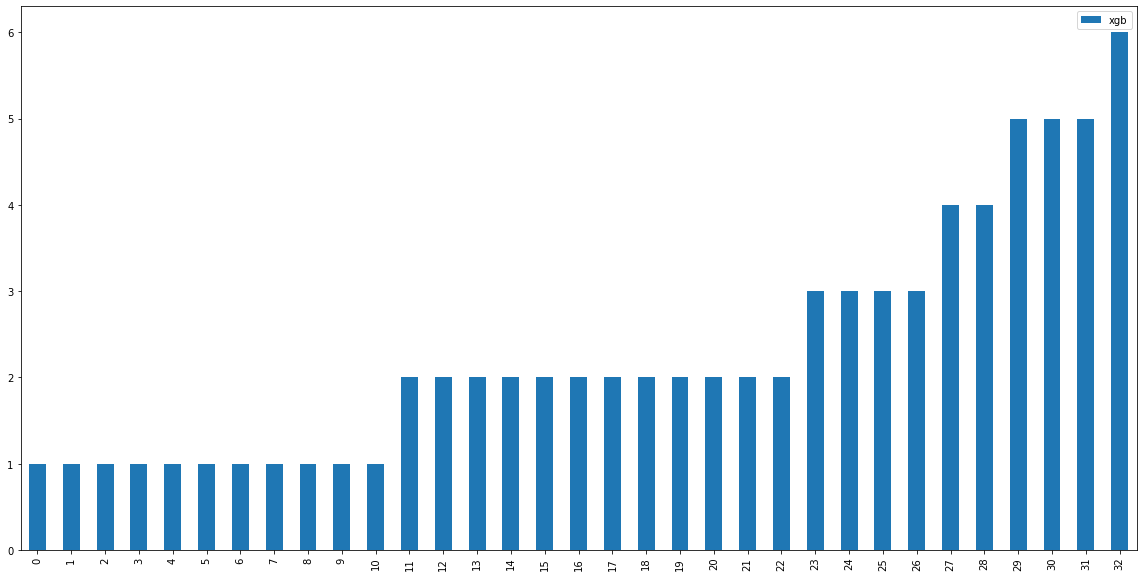

In [220]:
# plt.subplots(figsize=(20, 10))
xgb_importance.plot(kind="bar", figsize=(20,10))

In [305]:
imp = pd.merge(xgb_importance, importance_df, on="Feature")
imp.set_index('Feature', inplace=True)

In [306]:
imp = imp - imp.mean()
imp = imp/imp.std()

<AxesSubplot:xlabel='Feature'>

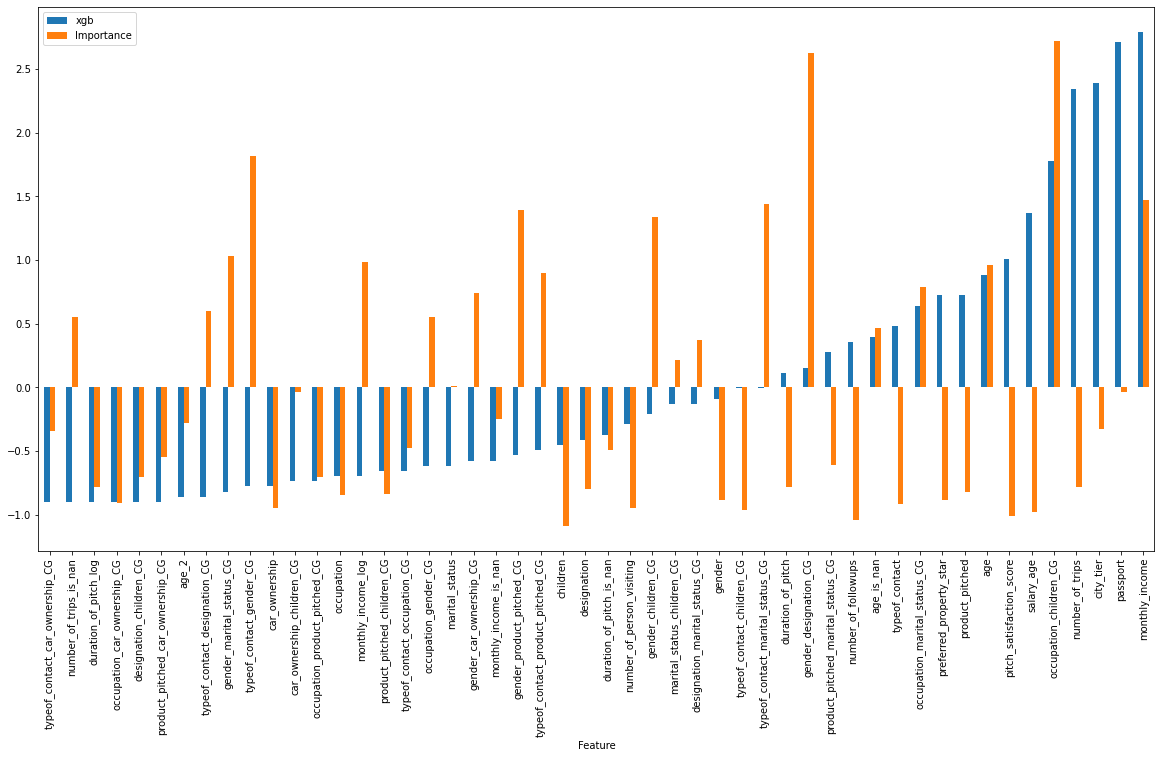

In [307]:
imp[["xgb", "Importance"]].plot(kind="bar", figsize=(20,10))

# create a sumbission file

In [257]:
train_df = train
valid_df = test

predictions = np.zeros(len(valid_df))
train_preds = np.zeros(len(valid_df))
import xgboost as xgb
lg = LogisticRegression()
params = {'n_estimators': 50, 'learning_rate': 0.390847220586157, 'max_depth': 1,  'booster' : "gbtree",
            "eval_metric": "auc",
            "tree_method": 'exact',
            'random_state': 1971,'subsample': 0.7113433792242354, 'colsample_bytree': 0.9489136845832957, 'min_child_weight': 6, 'gamma': 2.0270445702227686}
# params = {'n_estimators': 600, 'learning_rate': 0.018768615971126633, 'max_depth': 1, 'subsample': 0.6180301820309303, 'colsample_bytree': 0.9416678672737021, 'min_child_weight': 3}
model1 = xgb.XGBClassifier(**params)

In [258]:
k =1.409909059587222
f = 30.974750642190024
w = 11
missing = 34

In [259]:
weights = scores / np.sum(scores)

In [260]:
weights

array([0.19417272, 0.20486302, 0.20658887, 0.19503546, 0.19933992])

In [261]:
for model, weight in zip(models, weights) :
#     train_df = create_random_nan(train_df, missing)
    X_tr, X_val = create_feature(train_df, valid_df, y, CAT_COL, NUM_COL, CONT_COl, cv =skf, w=w, k=k, f =f)

#     model.fit(X_tr, y)

    train_preds +=  weight*model.predict_proba(X_tr)[:,1]
    predictions += weight*model.predict_proba(X_val)[:,1]

print(roc_auc_score(y, train_preds))

0.8601108657291341


In [262]:
# predictions= predictions/5.0

In [263]:
predictions

array([0.12246856, 0.1953267 , 0.263006  , ..., 0.65964886, 0.19892757,
       0.01206939])

In [264]:
submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit.head()

,0,1
0,3489,0.119451
1,3490,0.343575
2,3491,0.119451
3,3492,0.119451
4,3493,0.119451


In [265]:
submit[1] = predictions

In [266]:
submit.to_csv("submission.csv", index=False, header=None)

In [267]:
sum(submit[1]> 0.5)

219

In [185]:
# df["monthly_income"].plot(kind="hist")

In [186]:
# (train["monthly_income"]/ train["age"]).max()

In [371]:
############# kmeans 
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import sklearn
import scipy
class KMeansFeaturizer:
    """Transforms numeric data into k-means cluster memberships.
    
    This transformer runs k-means on the input data and converts each data point
    into the id of the closest cluster. If a target variable is present, it is 
    scaled and included as input to k-means in order to derive clusters that
    obey the classification boundary as well as group similar points together.

    Parameters
    ----------
    k: integer, optional, default 100
        The number of clusters to group data into.

    target_scale: float, [0, infty], optional, default 5.0
        The scaling factor for the target variable. Set this to zero to ignore
        the target. For classification problems, larger `target_scale` values 
        will produce clusters that better respect the class boundary.

    random_state : integer or numpy.RandomState, optional
        This is passed to k-means as the generator used to initialize the 
        kmeans centers. If an integer is given, it fixes the seed. Defaults to 
        the global numpy random number generator.

    Attributes
    ----------
    cluster_centers_ : array, [k, n_features]
        Coordinates of cluster centers. n_features does count the target column.
    """

    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.target_scale = target_scale
        self.random_state = random_state
        self.cluster_encoder = OneHotEncoder().fit(np.array(range(k)).reshape(-1,1))
        
    def fit(self, X, y=None):
        """Runs k-means on the input data and find centroids.

        If no target is given (`y` is None) then run vanilla k-means on input
        `X`. 

        If target `y` is given, then include the target (weighted by 
        `target_scale`) as an extra dimension for k-means clustering. In this 
        case, run k-means twice, first with the target, then an extra iteration
        without.

        After fitting, the attribute `cluster_centers_` are set to the k-means
        centroids in the input space represented by `X`.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            If provided, will be weighted with `target_scale` and included in 
            k-means clustering as hint.
        """
        if y is None:
            # No target variable, just do plain k-means
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              random_state=self.random_state)
            km_model.fit(X)

            self.km_model_ = km_model
            self.cluster_centers_ = km_model.cluster_centers_
            return self

        # There is target information. Apply appropriate scaling and include
        # into input data to k-means            
        data_with_target = np.hstack((X, y[:,np.newaxis]*self.target_scale))

        # Build a pre-training k-means model on data and target
        km_model_pretrain = KMeans(n_clusters=self.k, 
                                   n_init=20, 
                                   random_state=self.random_state)
        km_model_pretrain.fit(data_with_target)

        # Run k-means a second time to get the clusters in the original space
        # without target info. Initialize using centroids found in pre-training.
        # Go through a single iteration of cluster assignment and centroid 
        # recomputation.
        km_model = KMeans(n_clusters=self.k, 
                          init=km_model_pretrain.cluster_centers_[:,:2], 
                          n_init=1, 
                          max_iter=1)
        km_model.fit(X)
        
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
        
    def transform(self, X, y=None):
        """Outputs the closest cluster id for each input data point.

        Parameters
        ----------
        X : array-like or sparse matrix, shape=(n_data_points, n_features)

        y : vector of length n_data_points, optional, default None
            Target vector is ignored even if provided.

        Returns
        -------
        cluster_ids : array, shape[n_data_points,1]
        """
        clusters = self.km_model.predict(X)
        return self.cluster_encoder.transform(clusters.reshape(-1,1))
    
    def fit_transform(self, X, y=None):
        """Runs fit followed by transform.
        """
        self.fit(X, y)
        return self.transform(X, y)

In [381]:
km = KMeansFeaturizer(20)

In [382]:
km_train = km.fit_transform(X_tr[NUM_COL])

AttributeError: 'KMeansFeaturizer' object has no attribute 'km_model'

,age,city_tier,duration_of_pitch,number_of_person_visiting,number_of_followups,preferred_property_star,number_of_trips,pitch_satisfaction_score,monthly_income
0,0.926176,0.449462,0.068970,-1.912405,-0.083251,-0.730337,1.017236,1.319758,-1.352753
1,0.926176,-1.049819,-0.072972,-1.912405,-0.083251,-0.730337,-0.696458,1.319758,0.655467
2,4.413787,0.449462,0.494795,-1.912405,-0.112368,0.950703,-1.267690,2.208939,-0.380453
3,0.228654,1.948743,0.352854,-1.912405,-0.112368,0.950703,0.446005,1.319758,-1.292334
4,-1.863913,0.449462,0.210912,-1.912405,-0.112368,-0.730337,-0.696458,1.319758,-1.271461
...,...,...,...,...,...,...,...,...,...
2787,-0.468869,-1.049819,-0.924622,0.845567,-0.083251,-0.730337,1.017236,-0.458603,-0.464679
2788,0.228654,0.449462,1.630329,-0.533419,-0.112368,-0.730337,-0.125227,-1.347784,-1.286133
2789,0.228654,-1.049819,-0.782680,0.845567,-0.112368,2.631743,1.017236,0.430577,-1.265926
2790,-0.468869,-1.049819,-0.072972,0.845567,-0.141485,-0.730337,1.017236,1.319758,-0.506692


In [271]:
df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [10, 20, 30, 40, 50],
    'C': [100, 200, 300, 400, 500]
})

In [273]:
scaler = StandardScaler()

df[["A", "B"]] = scaler.fit_transform(df[["A", "B"]])

In [274]:
df

,A,B,C
0,-1.414214,-1.414214,100
1,-0.707107,-0.707107,200
2,0.000000,0.000000,300
3,0.707107,0.707107,400
4,1.414214,1.414214,500
